## 1. Packages & Initializations

In [96]:
from flask import Flask, request, jsonify, render_template, redirect, url_for, session, flash
from flask_sqlalchemy import SQLAlchemy
from werkzeug.security import check_password_hash, generate_password_hash
from abc import ABC, abstractmethod
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from arch import arch_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error
from itertools import product
import pickle
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta
import string
import random
import re
import base64
import io
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import optuna
# Suppress all warnings from statsmodels
warnings.filterwarnings("ignore", category=Warning, module='statsmodels')

In [3]:
app = Flask(__name__)
# Configure the SQLAlchemy part of the app instance
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///aidea.db'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
app.secret_key = 'Doggan98-ddd'
# Create the SQLAlchemy db instance
db = SQLAlchemy(app)

## 2. Models

### 2.0 Model Class Abstraction

In [4]:
class Model(ABC):
    def __init__(self, data, open, high, low, volume, symbol_name):
        self.data = data
        self.open = open
        self.volume = volume
        self.high = high
        self.low = low
        self.symbol_name = symbol_name

    @abstractmethod
    def train(self):
        """
        Abstract method to train the model.
        """
        pass
    
    @abstractmethod
    def forecast(self, forecast_days):
        """
        Abstract method to make predictions using the trained model.
        """
        pass

### 2.1 AR Model

In [122]:
class AR_model(Model):

    def prepare_data(self, data):
        data = data.dropna()
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        if not data.index.freq:
            # Attempt to infer the frequency
            inferred_freq = pd.infer_freq(data.index)
            if inferred_freq:
                data.index.freq = inferred_freq
            else:
                # Handle the case where frequency cannot be inferred
                # For example, you might decide to use a default frequency or handle this as an exception
                print("Unable to infer frequency for the datetime index.")

        data.index.length = len(data)
        return data
    
    def __init__(self, data, symbol_name):
        #data = self.prepare_data(data)
        super().__init__(data = data['Close'], open = data['Open'], high = data['High'], low = data['Low'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Autoregressive'
        self.stationary = False
        self.show_backtest = True

    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        self.stationary = p_value < alpha
        return self.stationary 

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def train(self):
            # Check stationarity and apply log transformation if needed
            data = self.data
            if not self.check_stationarity(self.data):
                print("Series is not stationary. Applying log transformation...")
                data = self.log_transform(self.data)
                    
            # Define parameter grid for tuning
            trends = ['n', 'c', 't', 'ct']
            min_lag = 1
            max_lag = int(np.sqrt(len(data))) if len(data) >= 20 else len(data) // 2  # Ensure a practical upper bound for small datasets
            lags_range = range(min_lag, max_lag + 1) 

            best_mse = float('inf')
            best_params = 'n', 1
            self.last_val_predictions = None  # To store the last validation split predictions
            self.last_val_index = None  # To store the index of the last validation split

            # Perform grid search with cross-validation on the training set
            # Choose the best params based on MSE score
            n_splits = 2
            tscv = TimeSeriesSplit(n_splits=n_splits)  # Time series cross-validation
            warnings.filterwarnings("ignore")
            for trend, lags in product(trends, lags_range):
                mse_sum = 0
                val_predictions = None
                val_index = None
                for train_index, val_index in tscv.split(data):
                    train_split, val_split = data.iloc[train_index], data.iloc[val_index]
                    try:
                        model = AutoReg(train_split.values, lags=lags, trend=trend).fit()
                        predictions = model.predict(start=len(train_split), end=len(train_split) + len(val_split) - 1)

                        mse = mean_squared_error(val_split, predictions)
                        mse_sum += mse
                        # Store the predictions and index of the last validation split
                        if val_index[0] == len(data) - len(val_split):
                           val_predictions = predictions
                           val_index = val_index
                    except Exception as e:
                        continue
                
                # Average mse score across folds
                avg_mse = mse_sum / n_splits
                
                # Update best parameters if better mse found
                if avg_mse < best_mse:
                    best_mse = avg_mse
                    best_params = (trend, lags)
                    self.last_val_predictions = val_predictions
                    self.last_val_index = val_index

            best_trend, best_lags = best_params
        
            print(f"Best MSE score: {best_mse:.4f}")
            print(f"Best parameters: trend={best_trend}, lags={best_lags}")
        
            # Fit the best model on the entire dataset 
            try:
                self.trained_model = AutoReg(data, lags=best_lags, trend=best_trend).fit()
                print(f'Model training successful')
            except Exception as e:
                print(f'Model training failed with the error message: {e}')
            
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.predict(start=start, end=end)
       # Reverse log transformation if applied
        if not self.stationary:
            forecast_prices = np.exp(forecast_prices)
            if self.last_val_predictions is not None and self.last_val_index is not None:
               self.last_val_predictions = np.exp(self.last_val_predictions)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Create candlestick data
        candlestick_data = pd.DataFrame({
            'Date': self.data.index,
            'Open': self.open,
            'Close': self.data,
            'High': self.high,
            'Low': self.low
        })
        # Plot the candlestick data with decreased transparency
        for idx, row in candlestick_data.iterrows():
            date_num = mdates.date2num(row['Date'])
            if row['Close'] >= row['Open']:
                color = 'green'
                lower = row['Open']
                height = row['Close'] - row['Open']
            else:
                color = 'red'
                lower = row['Close']
                height = row['Open'] - row['Close']
            
            # Draw high and low lines (wicks) outside the rectangle
            ax1.vlines(date_num, row['Low'], lower, color=color, alpha=0.5, linewidth=0.5)
            ax1.vlines(date_num, lower + height, row['High'], color=color, alpha=0.5, linewidth=0.5)
            
            # Draw the rectangle (candlestick body)
            ax1.add_patch(mpatches.Rectangle((date_num - 0.5, lower), 1, height, edgecolor=color, facecolor=color, alpha=1, linewidth=1))
        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='gray', linewidth=1, alpha=0.6)
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='black', linewidth=1.5, linestyle = '-')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold', fontsize = 16)
        ax1.set_ylabel('Price', weight = 'bold', fontsize = 15)
       
        ax1.grid(True, alpha = 0.3)
        # Plot the last validation split predictions if available
        if self.show_backtest:
            if self.last_val_predictions is not None and self.last_val_index is not None:
                ax1.plot(self.data.index[self.last_val_index], self.last_val_predictions, label='Backtest Predictions', color='dimgray', linewidth=1.5, linestyle='-')
        ax1.legend(loc='upper left')
        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold', fontsize = 15)
        ax2.set_xlabel('Time', weight = 'bold', fontsize = 15)
        ax2.grid(True, alpha = 0.3)
        
        # Save plot to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plot_data = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        plt.show()
        #plt.close(fig)  # Close the plot to free up resources

        return plot_data

[*********************100%***********************]  1 of 1 completed
Series is not stationary. Applying log transformation...
Best MSE score: 0.0157
Best parameters: trend=c, lags=11
Model training successful


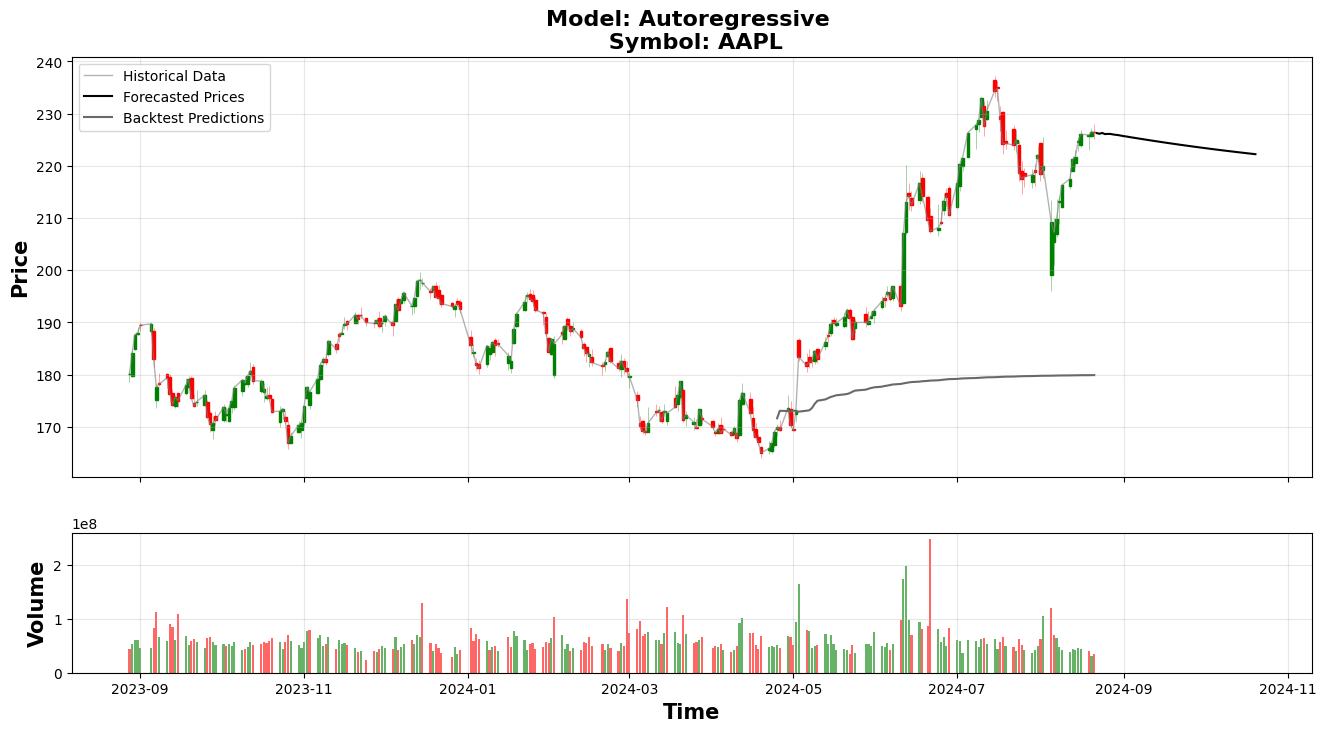

'iVBORw0KGgoAAAANSUhEUgAABkAAAAMgCAYAAAB7wK5aAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3xUVfrH8c+UTCa9kITQQui9iwq4CMoCgoquXVCw7wquoFhYG+pa1rL21f2pCyoqrrpYEFFAsdBB6RA6QwshIb1MMjP390fMNUMSSCCN5Pv2NS/m3nvuuc+dOQkyz5zzWAzDMBAREREREREREREREWlArHUdgIiIiIiIiIiIiIiISHVTAkRERERERERERERERBocJUBERERERERERERERKTBUQJEREREREREREREREQaHCVARERERERERERERESkwVECREREREREREREREREGhwlQEREREREREREREREpMFRAkRERERERERERERERBocJUBERERERERERERERKTBUQJEREREREREREREREQaHCVARERERERERERERESkwVECREREREREREREREREGhwlQEREREREREREREREpMFRAkRERERERERERERERBocJUBERERERERERERERKTBUQJEREREREREREREREQaHCVARERERERERERERESkwVECREREREREREREREREGhwlQEREREREREREREREpMFRAkRERERERERERERERBocJUBERERERERERERERKTBUQJEREREREREREREREQaHCVARERERERERERERESkwVECREREREREREREREREGhwlQEREREREREREREREpMFRAkRERERERERERERERBocJUBERERERERERERERKTBUQJEREREREREREREREQaHCVARERERERERERERESkwVECREREREREREREREREGhwlQEREREREREREREREpMFRAkRERERERERERERERBocJUB

In [123]:
symbol = 'AAPL'
data_length = 360
forecast_days = 60
model_type = 'AR'
#Set start and end date
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol, start_date, end_date)
model = AR_model(data, symbol)
model.train()
model.forecast(forecast_days)

### 2.2 ARIMA Model

In [118]:
class ARIMA_model(Model):

    def prepare_data(self, data):
        data = data.dropna()
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        if not data.index.freq:
            # Attempt to infer the frequency
            inferred_freq = pd.infer_freq(data.index)
            if inferred_freq:
                data.index.freq = inferred_freq
            else:
                # Handle the case where frequency cannot be inferred
                # For example, you might decide to use a default frequency or handle this as an exception
                print("Unable to infer frequency for the datetime index.")

        data.index.length = len(data)
        return data
    
    def __init__(self, data, symbol_name):
        #data = self.prepare_data(data)
        super().__init__(data = data['Close'], open = data['Open'], high = data['High'], low = data['Low'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Autoregressive Integrated Moving Average'
        self.stationary = False
        self.show_backtest = True
    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        self.stationary = p_value < alpha
        return self.stationary 

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def train(self):
            # Check stationarity and apply log transformation if needed
            data = self.data
            if not self.check_stationarity(self.data):
                print("Series is not stationary. Applying log transformation...")
                data = self.log_transform(self.data)
                    
            # Define parameter grid for tuning
            p_values = range(0, 3)
            d_values = range(0, 2)
            q_values = range(0, 3)
            trends = ['c', 't', 'ct', [0, 0, 1, 0], [0, 0, 0, 1]]
            
            best_mse = float('inf') 
            best_params = 'c', 0, 0, 0
            self.last_val_predictions = None  # To store the last validation split predictions
            self.last_val_index = None  # To store the index of the last validation split

            # Perform grid search with cross-validation on the training set
            # Choose the best params based on MSE score
            n_splits = 2
            tscv = TimeSeriesSplit(n_splits=n_splits)  # Time series cross-validation
            warnings.filterwarnings("ignore")
            for d in d_values:
                if d == 1:
                    trends = ['t', [0,0,1,0], [0, 0, 0, 1]]
                elif d == 2:
                    trends = [[0,0,1,0], [0,0,0,1]]
                elif d == 0:
                    trends = ['c', 't', 'ct', [0, 0, 1, 0], [0, 0, 0, 1]]
                for trend in trends:
                    for p in p_values:   
                        for q in q_values:
                            mse_sum = 0
                            val_predictions = None
                            val_index = None
                            for train_index, val_index in tscv.split(data):
                                train_split, val_split = data.iloc[train_index], data.iloc[val_index]
                                try:
                                    model = ARIMA(train_split, order=(p,d,q), trend = trend).fit()
                                    predictions = model.predict(start=len(train_split), end=len(train_split) + len(val_split) - 1)
                                    mse = mean_squared_error(val_split, predictions)
                                    mse_sum += mse
                                    # Store the predictions and index of the last validation split
                                    if val_index[0] == len(data) - len(val_split):
                                        val_predictions = predictions
                                        val_index = val_index
                                except Exception as e:
                                    continue

                            avg_mse = mse_sum / n_splits
                            if avg_mse < best_mse:
                                best_mse = avg_mse
                                best_params = (trend, p, d, q)
                                self.last_val_predictions = val_predictions
                                self.last_val_index = val_index

            best_trend, best_p, best_d, best_q = best_params
            print(f"Best MSE score: {best_mse:.4f}")
            print(f"Best parameters: trend={best_trend}, p={best_p}, d={best_d}, q={best_q}")
        
            # Fit the best model on the entire dataset 
            try:
                self.trained_model = ARIMA(data, order=(best_p,best_d,best_q), trend=best_trend).fit()
                print(f'Model training successful')
            except Exception as e:
                print(f'Model training failed with the error message: {e}')
            
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.predict(start=start, end=end)
       # Reverse log transformation if applied
        if not self.stationary:
            forecast_prices = np.exp(forecast_prices)
            if self.last_val_predictions is not None and self.last_val_index is not None:
                self.last_val_predictions = np.exp(self.last_val_predictions)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Create candlestick data
        candlestick_data = pd.DataFrame({
            'Date': self.data.index,
            'Open': self.open,
            'Close': self.data,
            'High': self.high,
            'Low': self.low
        })
        # Plot the candlestick data with decreased transparency
        for idx, row in candlestick_data.iterrows():
            date_num = mdates.date2num(row['Date'])
            if row['Close'] >= row['Open']:
                color = 'green'
                lower = row['Open']
                height = row['Close'] - row['Open']
            else:
                color = 'red'
                lower = row['Close']
                height = row['Open'] - row['Close']
            
            # Draw high and low lines (wicks) outside the rectangle
            ax1.vlines(date_num, row['Low'], lower, color=color, alpha=0.5, linewidth=0.5)
            ax1.vlines(date_num, lower + height, row['High'], color=color, alpha=0.5, linewidth=0.5)
            
            # Draw the rectangle (candlestick body)
            ax1.add_patch(mpatches.Rectangle((date_num - 0.5, lower), 1, height, edgecolor=color, facecolor=color, alpha=1, linewidth=1))

        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='gray', linewidth=1, alpha=0.6)
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='black', linewidth=1.5, linestyle = '-')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold', fontsize = 16)
        ax1.set_ylabel('Price', weight = 'bold', fontsize = 15)
        ax1.grid(True, alpha = 0.3)

        # Plot the last validation split predictions if available
        if self.show_backtest:
            if self.last_val_predictions is not None and self.last_val_index is not None:
                ax1.plot(self.data.index[self.last_val_index], self.last_val_predictions, label='Backtest Predictions', color='dimgray', linewidth=1.5, linestyle='-')

        ax1.legend(loc='upper left')
        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold', fontsize = 15)
        ax2.set_xlabel('Time', weight = 'bold', fontsize = 15)
        ax2.grid(True, alpha = 0.3)
        
        # Save plot to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plot_data = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        plt.show()
        #plt.close(fig)  # Close the plot to free up resources

        return plot_data

[*********************100%***********************]  1 of 1 completed
Series is not stationary. Applying log transformation...
Best MSE score: 0.0031
Best parameters: trend=t, p=2, d=1, q=2
Model training successful


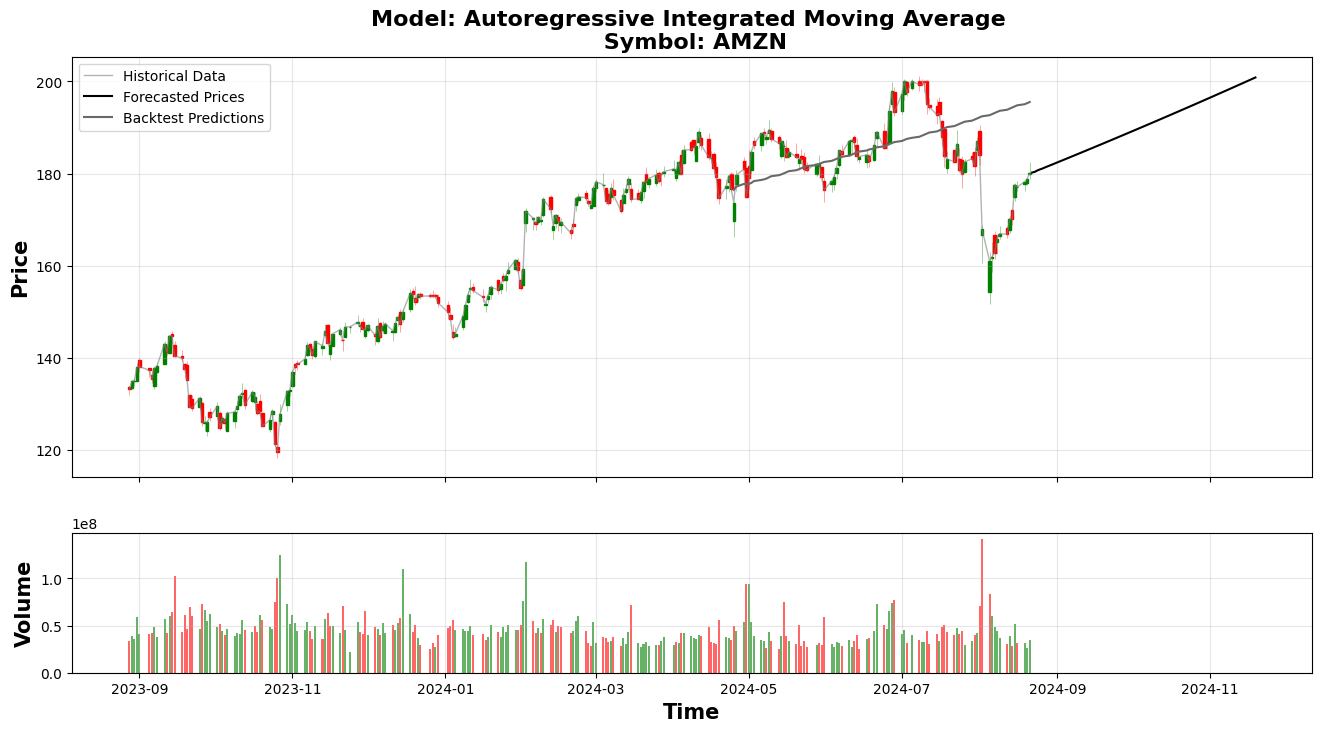

'iVBORw0KGgoAAAANSUhEUgAABkAAAAMgCAYAAAB7wK5aAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd1QU198G8GdhWZbekV5EVFTsXaNgb7EES4zGrm9UrDHRFKPpiTGxm6IJGEvsJrafxq6xl6hgQUERC116W5ad9w9kwrCAoHSfzzl7ZG6ZuTM7O8j97r1XJgiCACIiIiIiIiIiIiIiohpEp7IbQEREREREREREREREVNYYACEiIiIiIiIiIiIiohqHARAiIiIiIiIiIiIiIqpxGAAhIiIiIiIiIiIiIqIahwEQIiIiIiIiIiIiIiKqcRgAISIiIiIiIiIiIiKiGocBECIiIiIiIiIiIiIiqnEYACEiIiIiIiIiIiIiohqHARAiIiIiIiIiIiIiIqpxGAAhIiIiIiIiIiIiIqIahwEQIiIiIiIiIiIiIiKqcRgAISIiIiIiIiIiIiKiGocBECIiIiIiIiIiIiIiqnEYACEiIiIiIiIiIiIiohqHARAiIiIiIiIiIiIiIqpxGAAhIiIiIiIiIiIiIqIahwEQIiIiIiIiIiIiIiKqcRgAISIiIiIiIiIiIiKiGocBECIiIiIiIiIiIiIiqnEYACEiIiIiIiIiIiIiohqHARAiIiIiIiIiIiIiIqpxGAAhIiIiIiIiIiIiIqIahwEQIiIiIiIiIiIiIiKqcRgAISIiIiIiIiIiIiKiGocBECIiIiIiIiIiIiIiqnEYACEiIiIiIiIiIiIiohqHARAiIiIiIiIiIiIiIqpxGAAhIiIiIiIiIiIiIqIahwEQIiIiIiIiIiIiIiKqcRgAISIiIiIiIiIiIiKiGocBECIiIiIiIiIiIiIiqnEYACEiIiIiIiIiIiIiohqHARAiIiIiIiIiIiI

In [119]:
symbol = 'AMZN'
data_length = 360
forecast_days = 90
#Set start and end date
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol, start_date, end_date)
model = ARIMA_model(data, symbol)
model.train()
model.forecast(forecast_days)


### 2.3 SARIMA Model

In [116]:
class SARIMA_model(Model):

    def prepare_data(self, data):
        data = data.dropna()
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        if not data.index.freq:
            # Attempt to infer the frequency
            inferred_freq = pd.infer_freq(data.index)
            if inferred_freq:
                data.index.freq = inferred_freq
            else:
                # Handle the case where frequency cannot be inferred
                # For example, you might decide to use a default frequency or handle this as an exception
                print("Unable to infer frequency for the datetime index.")

        data.index.length = len(data)
        return data
    
    def __init__(self, data, symbol_name):
        #data = self.prepare_data(data)
        super().__init__(data = data['Close'], open = data['Open'], high = data['High'], low = data['Low'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Seasonal Autoregressive Integrated Moving Average'
        self.stationary = False
        self.show_backtest = True

    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        self.stationary = p_value < alpha
        return self.stationary 

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def objective(self, trial):
        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 3)
        P = trial.suggest_int('P', 0, 2)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 2)
        s = trial.suggest_categorical('s', [7, 12, 30, 52])  # Example seasonal periods
        trend = trial.suggest_categorical('trend', ['c', 't', 'ct'])

        mse_sum = 0
        n_splits = 2
        best_val_predictions = None
        best_val_index = None
        tscv = TimeSeriesSplit(n_splits=n_splits)
        # Retrieve the current best_mse from user attributes
        best_mse = trial.user_attrs.get('best_mse', float('inf'))

        warnings.filterwarnings("ignore")
        for train_index, val_index in tscv.split(self.data):
            train_split, val_split = self.data.iloc[train_index], self.data.iloc[val_index]
            try:
                model = SARIMAX(train_split, order=(p, d, q), seasonal_order=(P, D, Q, s), trend=trend).fit(disp = False)
                predictions = model.predict(start=len(train_split), end=len(train_split) + len(val_split) - 1)
                mse = mean_squared_error(val_split, predictions)
                mse_sum += mse
                # Store the predictions and index for the last validation split
                if len(val_index) > 0 and val_index[0] == len(self.data) - len(val_split):
                    best_val_predictions = predictions
                    best_val_index = val_index
            except Exception as e:
                print(e)
                return float('inf')  # Return a very low value if an error occurs

        avg_mse = mse_sum / n_splits
        if avg_mse<best_mse:
            # Store the best predictions and index within the trial object for later retrieval
            trial.set_user_attr("best_mse", avg_mse)
            trial.set_user_attr("best_val_predictions", best_val_predictions)
            trial.set_user_attr("best_val_index", best_val_index)

        return avg_mse
    
    def train(self):
            # Check stationarity and apply log transformation if needed
            if not self.check_stationarity(self.data):
                print("Series is not stationary. Applying log transformation...")
                self.data = self.log_transform(self.data)
                    
             # Create an Optuna study
            study = optuna.create_study(direction='minimize')
            # Define an initial best_mse as infinity
            initial_best_mse = float('inf')
            # Define the objective function with an initial best_mse
            def objective_with_initial_best_mse(trial):
                trial.set_user_attr("best_mse", initial_best_mse)
                return self.objective(trial)

            study.optimize(objective_with_initial_best_mse, n_trials=30)  # Number of trials can be adjusted


            best_params = study.best_params
            best_mse = study.best_value  # Access custom attributes returned from objective function

            # Retrieve the best trial
            best_trial = study.best_trial

            # Store the best validation predictions and index
            self.last_val_predictions = best_trial.user_attrs["best_val_predictions"]
            self.last_val_index = best_trial.user_attrs["best_val_index"]

            
            print(f"Best MSE score: {best_mse:.4f}")
            print(f"Best parameters: {best_params}")

            # Fit the best model on the entire dataset
            try:
                self.trained_model = SARIMAX(self.data, order=(best_params['p'], best_params['d'], best_params['q']),
                                            seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']),
                                            trend=best_params['trend']).fit(disp = False)
                print(f'Model training successful')
            except Exception as e:
                print(f'Model training failed with the error message: {e}')
            
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.predict(start=start, end=end)
       # Reverse log transformation if applied
        if not self.stationary:
            self.data = np.exp(self.data)
            forecast_prices = np.exp(forecast_prices)
            if self.last_val_predictions is not None and self.last_val_index is not None:
                self.last_val_predictions = np.exp(self.last_val_predictions)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Create candlestick data
        candlestick_data = pd.DataFrame({
            'Date': self.data.index,
            'Open': self.open,
            'Close': self.data,
            'High': self.high,
            'Low': self.low
        })
        # Plot the candlestick data with decreased transparency
        for idx, row in candlestick_data.iterrows():
            date_num = mdates.date2num(row['Date'])
            if row['Close'] >= row['Open']:
                color = 'green'
                lower = row['Open']
                height = row['Close'] - row['Open']
            else:
                color = 'red'
                lower = row['Close']
                height = row['Open'] - row['Close']
            
            # Draw high and low lines (wicks) outside the rectangle
            ax1.vlines(date_num, row['Low'], lower, color=color, alpha=0.5, linewidth=0.5)
            ax1.vlines(date_num, lower + height, row['High'], color=color, alpha=0.5, linewidth=0.5)
            
            # Draw the rectangle (candlestick body)
            ax1.add_patch(mpatches.Rectangle((date_num - 0.5, lower), 1, height, edgecolor=color, facecolor=color, alpha=1, linewidth=1))
        
        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='gray', linewidth=1, alpha=0.6)
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='black', linewidth=1.5, linestyle = '-')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold', fontsize = 16)
        ax1.set_ylabel('Price', weight = 'bold', fontsize = 15)
        ax1.grid(True, alpha = 0.3)

        # Plot the last validation split predictions if available
        if self.show_backtest:
            if self.last_val_predictions is not None and self.last_val_index is not None:
                ax1.plot(self.data.index[self.last_val_index], self.last_val_predictions, label='Backtest Predictions', color='dimgray', linewidth=1.5, linestyle='-')

        ax1.legend(loc='upper left')
        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold', fontsize = 15)
        ax2.set_xlabel('Time', weight = 'bold', fontsize = 15)
        ax2.grid(True, alpha = 0.3)
        
        # Save plot to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plot_data = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        plt.show()
        #plt.close(fig)  # Close the plot to free up resources

        return plot_data

[*********************100%***********************]  1 of 1 completed

[I 2024-08-22 13:04:29,030] A new study created in memory with name: no-name-f04edd2c-fb91-41e8-bf90-fdfb4bb4c2f4



Series is not stationary. Applying log transformation...


[I 2024-08-22 13:04:32,543] Trial 0 finished with value: 0.14592408234011534 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 2, 's': 30, 'trend': 't'}. Best is trial 0 with value: 0.14592408234011534.
[I 2024-08-22 13:04:41,033] Trial 1 finished with value: 0.018144306333260952 and parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 's': 30, 'trend': 't'}. Best is trial 1 with value: 0.018144306333260952.
[I 2024-08-22 13:04:56,768] Trial 2 finished with value: 72.36782569369383 and parameters: {'p': 0, 'd': 2, 'q': 2, 'P': 0, 'D': 1, 'Q': 2, 's': 52, 'trend': 't'}. Best is trial 1 with value: 0.018144306333260952.
[I 2024-08-22 13:05:06,263] Trial 3 finished with value: 15.0831553209674 and parameters: {'p': 1, 'd': 2, 'q': 0, 'P': 2, 'D': 0, 'Q': 2, 's': 30, 'trend': 'c'}. Best is trial 1 with value: 0.018144306333260952.
[I 2024-08-22 13:05:26,685] Trial 4 finished with value: 6.038733810462804 and parameters: {'p': 1, 'd': 1, 'q': 3, 'P': 0, 'D': 1, 'Q': 2, '

Best MSE score: 0.0106
Best parameters: {'p': 0, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 1, 's': 7, 'trend': 't'}
Model training successful


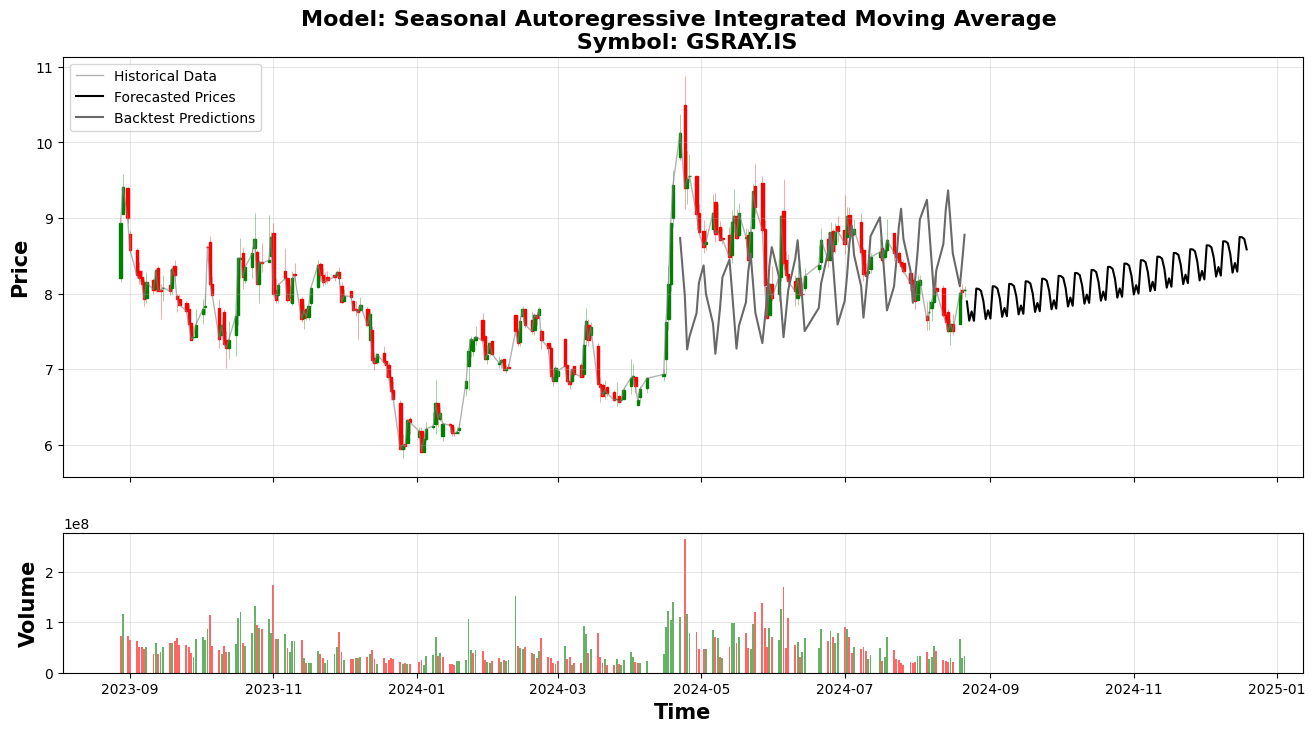

'iVBORw0KGgoAAAANSUhEUgAABkAAAAMgCAYAAAB7wK5aAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3wUxd8H8M+VXC49kE4JoYTeqyC99y6KKE3BAioggjyCIih2BSzoz0IUpEgVRUFEei8CCZ1QgkgSQkjP5do8f4Rbb6+kN5LPm9e9yO7szM7uze0l+92ZUQghBIiIiIiIiIiIiIiIiMoRZWlXgIiIiIiIiIiIiIiIqKgxAEJEREREREREREREROUOAyBERERERERERERERFTuMABCRERERERERERERETlDgMgRERERERERERERERU7jAAQkRERERERERERERE5Q4DIEREREREREREREREVO4wAEJEREREREREREREROUOAyBERERERERERERERFTuMABCRERERERERERERETlDgMgRERERERERERERERU7jAAQkRERERERERERERE5Q4DIEREREREREREREREVO4wAEJEREREREREREREROUOAyBERERERERERERERFTuMABCRERERERERERERETlDgMgRERERERERERERERU7jAAQkRERERERERERERE5Q4DIEREREREREREREREVO4wAEJEREREREREREREROUOAyBERERERERERERERFTuMABCRERERERERERERETlDgMgRERERERERERERERU7jAAQkRERERERERERERE5Q4DIEREREREREREREREVO4wAEJEREREREREREREROUOAyBERERERERERERERFTuMABCRERERERERERERETlDgMgRERERERERERERERU7jAAQkRERERERERERERE5Q4DIEREREREREREREREVO4wAEJEREREREREREREROUOAyBERERERERERER

In [117]:
symbol = 'GSRAY.IS'
data_length = 360
forecast_days = 120
#Set start and end date
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol, start_date, end_date)
model = SARIMA_model(data, symbol)
model.train()
model.forecast(forecast_days)

### 2.4 Holt-Winters Exponential Smoothing

In [114]:
class HWES_model(Model):
    def prepare_data(self, data):
        data = data.dropna()
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        if not data.index.freq:
            # Attempt to infer the frequency
            inferred_freq = pd.infer_freq(data.index)
            if inferred_freq:
                data.index.freq = inferred_freq
            else:
                # Handle the case where frequency cannot be inferred
                # For example, you might decide to use a default frequency or handle this as an exception
                print("Unable to infer frequency for the datetime index.")

        data.index.length = len(data)
        return data
    
    def __init__(self, data, symbol_name):
        #data = self.prepare_data(data)
        super().__init__(data = data['Close'], open = data['Open'], high = data['High'], low = data['Low'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Holt-Winters Exponential Smoothing'
        self.stationary = False
        self.show_backtest = True

    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        self.stationary = p_value < alpha
        return self.stationary 

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def objective(self, trial):

        # Define range of parameters
        trend = trial.suggest_categorical('trend', ['add', 'mul', 'additive', 'multiplicative'])
        seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', 'additive', 'multiplicative'])
        seasonal_periods = trial.suggest_categorical('seasonal_periods', [7, 12, 30, 52])  # Example seasonal periods
        initialization_method = trial.suggest_categorical('initialization_method', [None, 'estimated', 'heuristic', 'legacy-heuristic'])
        use_boxcox = trial.suggest_categorical('use_boxcox', [True, False])
        mse_sum = 0
        n_splits = 2
        best_val_predictions = None
        best_val_index = None
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
         # Retrieve the current best_mse from user attributes
        best_mse = trial.user_attrs.get('best_mse', float('inf'))

        warnings.filterwarnings("ignore")
        for train_index, val_index in tscv.split(self.data):
            train_split, val_split = self.data.iloc[train_index], self.data.iloc[val_index]
            try:
                model = ExponentialSmoothing(train_split, trend = trend, seasonal = seasonal, 
                                             seasonal_periods = seasonal_periods,
                                             initialization_method = initialization_method,
                                             use_boxcox = use_boxcox).fit()
                predictions = model.predict(start=len(train_split), end=len(train_split) + len(val_split) - 1)
                mse = mean_squared_error(val_split, predictions)
                mse_sum += mse
                # Store the predictions and index for the last validation split
                if len(val_index) > 0 and val_index[0] == len(self.data) - len(val_split):
                    best_val_predictions = predictions
                    best_val_index = val_index
            except Exception as e:
                print(e)
                return float('inf')  # Return a very low value if an error occurs

        avg_mse = mse_sum / n_splits
        # Store the best predictions and index within the trial object for later retrieval
        if avg_mse < best_mse:
            trial.set_user_attr('best_mse', avg_mse)
            trial.set_user_attr("best_val_predictions", best_val_predictions)
            trial.set_user_attr("best_val_index", best_val_index)
        return avg_mse
    
    def train(self):
        # Check stationarity and apply log transformation if needed
        if not self.check_stationarity(self.data):
            print("Series is not stationary. Applying log transformation...")
            self.data = self.log_transform(self.data)
                
            # Create an Optuna study
        study = optuna.create_study(direction='minimize')
        # Define an initial best_mse as infinity
        initial_best_mse = float('inf')
        # Define the objective function with an initial best_mse
        def objective_with_initial_best_mse(trial):
            trial.set_user_attr("best_mse", initial_best_mse)
            return self.objective(trial)

        study.optimize(objective_with_initial_best_mse, n_trials=75)  # Number of trials can be adjusted

        best_params = study.best_params
        best_mse = study.best_value  # Access custom attributes returned from objective function

        # Retrieve the best trial
        best_trial = study.best_trial

        # Store the best validation predictions and index
        self.last_val_predictions = best_trial.user_attrs["best_val_predictions"]
        self.last_val_index = best_trial.user_attrs["best_val_index"]

        
        print(f"Best MSE score: {best_mse:.4f}")
        print(f"Best parameters: {best_params}")

        # Fit the best model on the entire dataset
        try:
            self.trained_model = ExponentialSmoothing(self.data, trend = best_params['trend'], seasonal = best_params['seasonal'],
                                                        seasonal_periods = best_params['seasonal_periods'], 
                                                        initialization_method = best_params['initialization_method'],
                                                        use_boxcox = best_params['use_boxcox']).fit()
            print(f'Model training successful')
        except Exception as e:
            print(f'Model training failed with the error message: {e}')
            
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.predict(start=start, end=end)
       # Reverse log transformation if applied
        if not self.stationary:
            self.data = np.exp(self.data)
            forecast_prices = np.exp(forecast_prices)
            if self.last_val_predictions is not None and self.last_val_index is not None:
                self.last_val_predictions = np.exp(self.last_val_predictions)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Create candlestick data
        candlestick_data = pd.DataFrame({
            'Date': self.data.index,
            'Open': self.open,
            'Close': self.data,
            'High': self.high,
            'Low': self.low
        })
        # Plot the candlestick data with decreased transparency
        for idx, row in candlestick_data.iterrows():
            date_num = mdates.date2num(row['Date'])
            if row['Close'] >= row['Open']:
                color = 'green'
                lower = row['Open']
                height = row['Close'] - row['Open']
            else:
                color = 'red'
                lower = row['Close']
                height = row['Open'] - row['Close']
            
            # Draw high and low lines (wicks) outside the rectangle
            ax1.vlines(date_num, row['Low'], lower, color=color, alpha=0.5, linewidth=0.5)
            ax1.vlines(date_num, lower + height, row['High'], color=color, alpha=0.5, linewidth=0.5)
            
            # Draw the rectangle (candlestick body)
            ax1.add_patch(mpatches.Rectangle((date_num - 0.5, lower), 1, height, edgecolor=color, facecolor=color, alpha=1, linewidth=1))
        
        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='gray', linewidth=1, alpha=0.6)
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='black', linewidth=1.5, linestyle = '-')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold', fontsize = 16)
        ax1.set_ylabel('Price', weight = 'bold', fontsize = 15)
        ax1.grid(True, alpha = 0.3)

        # Plot the last validation split predictions if available
        if self.show_backtest:
            if self.last_val_predictions is not None and self.last_val_index is not None:
                ax1.plot(self.data.index[self.last_val_index], self.last_val_predictions, label='Backtest Predictions', color='dimgray', linewidth=1.5, linestyle='-')

        ax1.legend(loc='upper left')
        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold', fontsize = 15)
        ax2.set_xlabel('Time', weight = 'bold', fontsize = 15)
        ax2.grid(True, alpha = 0.3)
        
        # Save plot to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plot_data = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        plt.show()
        #plt.close(fig)  # Close the plot to free up resources

        return plot_data

[*********************100%***********************]  1 of 1 completed

[I 2024-08-22 13:02:48,049] A new study created in memory with name: no-name-a101f63a-d35e-442f-8207-e6f77166d330
[I 2024-08-22 13:02:48,053] Trial 0 finished with value: inf and parameters: {'trend': 'multiplicative', 'seasonal': 'add', 'seasonal_periods': 52, 'initialization_method': None, 'use_boxcox': False}. Best is trial 0 with value: inf.
[I 2024-08-22 13:02:48,139] Trial 1 finished with value: inf and parameters: {'trend': 'mul', 'seasonal': 'multiplicative', 'seasonal_periods': 12, 'initialization_method': None, 'use_boxcox': True}. Best is trial 0 with value: inf.
[I 2024-08-22 13:02:48,217] Trial 2 finished with value: inf and parameters: {'trend': 'multiplicative', 'seasonal': 'multiplicative', 'seasonal_periods': 12, 'initialization_method': 'legacy-heuristic', 'use_boxcox': True}. Best is trial 0 with value: inf.



Series is not stationary. Applying log transformation...
could not broadcast input array from shape (43,) into shape (52,)
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').


[I 2024-08-22 13:02:48,299] Trial 3 finished with value: inf and parameters: {'trend': 'multiplicative', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'legacy-heuristic', 'use_boxcox': True}. Best is trial 0 with value: inf.
[I 2024-08-22 13:02:48,383] Trial 4 finished with value: inf and parameters: {'trend': 'additive', 'seasonal': 'multiplicative', 'seasonal_periods': 12, 'initialization_method': 'heuristic', 'use_boxcox': True}. Best is trial 0 with value: inf.


Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').


[I 2024-08-22 13:02:48,595] Trial 5 finished with value: 0.0038581491588609218 and parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 12, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 5 with value: 0.0038581491588609218.
[I 2024-08-22 13:02:48,599] Trial 6 finished with value: inf and parameters: {'trend': 'additive', 'seasonal': 'mul', 'seasonal_periods': 52, 'initialization_method': 'estimated', 'use_boxcox': True}. Best is trial 5 with value: 0.0038581491588609218.
[I 2024-08-22 13:02:48,602] Trial 7 finished with value: inf and parameters: {'trend': 'multiplicative', 'seasonal': 'mul', 'seasonal_periods': 52, 'initialization_method': 'estimated', 'use_boxcox': True}. Best is trial 5 with value: 0.0038581491588609218.
[I 2024-08-22 13:02:48,604] Trial 8 finished with value: inf and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 30, 'initialization_method': None, 'use_boxcox': False}. Best is trial 5 with value: 0.0038

Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
operands could not be broadcast together with shapes (13,) (30,) 
Input contains NaN, infinity or a value too large for dtype('float64').
Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


[I 2024-08-22 13:02:48,836] Trial 12 finished with value: 0.0034022594506615067 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': None, 'use_boxcox': False}. Best is trial 12 with value: 0.0034022594506615067.
[I 2024-08-22 13:02:48,997] Trial 13 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:49,131] Trial 14 finished with value: 0.0034022594506615067 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': None, 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:49,273] Trial 15 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False

operands could not be broadcast together with shapes (13,) (30,) 


[I 2024-08-22 13:02:50,761] Trial 26 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:50,920] Trial 27 finished with value: 0.0029993477974219985 and parameters: {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:51,081] Trial 28 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:51,093] Trial 29 finished with value: inf and parameters: {'trend': 'additive', 'seasonal': 'add', 'seasonal_periods': 30, 'initialization_method': 'legacy-heuristic', 'use_boxcox

operands could not be broadcast together with shapes (13,) (30,) 
Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


[I 2024-08-22 13:02:51,430] Trial 32 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:51,574] Trial 33 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:51,703] Trial 34 finished with value: 0.0029993477974219985 and parameters: {'trend': 'add', 'seasonal': 'multiplicative', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:51,775] Trial 35 finished with value: inf and parameters: {'trend': 'multiplicative', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'legacy-heuristic', 

Input contains NaN, infinity or a value too large for dtype('float64').


[I 2024-08-22 13:02:51,991] Trial 36 finished with value: 0.0038599056171726926 and parameters: {'trend': 'mul', 'seasonal': 'multiplicative', 'seasonal_periods': 12, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:52,072] Trial 37 finished with value: inf and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': True}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:52,213] Trial 38 finished with value: 0.002998452471958273 and parameters: {'trend': 'additive', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.


Input contains NaN, infinity or a value too large for dtype('float64').


[I 2024-08-22 13:02:52,299] Trial 39 finished with value: inf and parameters: {'trend': 'multiplicative', 'seasonal': 'mul', 'seasonal_periods': 12, 'initialization_method': 'estimated', 'use_boxcox': True}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:52,308] Trial 40 finished with value: inf and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 52, 'initialization_method': 'legacy-heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:52,454] Trial 41 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.


Input contains NaN, infinity or a value too large for dtype('float64').
operands could not be broadcast together with shapes (0,) (43,) 


[I 2024-08-22 13:02:52,596] Trial 42 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:52,804] Trial 43 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 13 with value: 0.002998452471958273.
[I 2024-08-22 13:02:53,021] Trial 44 finished with value: 0.0029976081734173574 and parameters: {'trend': 'mul', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:53,255] Trial 45 finished with value: 0.003917868792337034 and parameters: {'trend': 'mul', 'seasonal': 'multiplicative', 'seasonal_periods': 30, 'initialization_method

Input contains NaN, infinity or a value too large for dtype('float64').


[I 2024-08-22 13:02:53,550] Trial 47 finished with value: 0.0038581491588609218 and parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 12, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:53,559] Trial 48 finished with value: inf and parameters: {'trend': 'mul', 'seasonal': 'additive', 'seasonal_periods': 52, 'initialization_method': None, 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.


could not broadcast input array from shape (43,) into shape (52,)


[I 2024-08-22 13:02:53,794] Trial 49 finished with value: 0.0029985054049005665 and parameters: {'trend': 'mul', 'seasonal': 'mul', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:54,165] Trial 50 finished with value: 0.0034502090576682513 and parameters: {'trend': 'multiplicative', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'estimated', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:54,312] Trial 51 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:54,455] Trial 52 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 

Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


[I 2024-08-22 13:02:55,209] Trial 58 finished with value: 0.003403392468913676 and parameters: {'trend': 'add', 'seasonal': 'multiplicative', 'seasonal_periods': 7, 'initialization_method': None, 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:55,408] Trial 59 finished with value: 0.0038581491588609218 and parameters: {'trend': 'multiplicative', 'seasonal': 'add', 'seasonal_periods': 12, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:55,416] Trial 60 finished with value: inf and parameters: {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 52, 'initialization_method': 'legacy-heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:55,545] Trial 61 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'u

operands could not be broadcast together with shapes (0,) (43,) 


[I 2024-08-22 13:02:55,672] Trial 62 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:55,801] Trial 63 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:55,928] Trial 64 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:56,057] Trial 65 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxco

Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Input contains NaN, infinity or a value too large for dtype('float64').


[I 2024-08-22 13:02:56,533] Trial 70 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:56,673] Trial 71 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:56,824] Trial 72 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}. Best is trial 44 with value: 0.0029976081734173574.
[I 2024-08-22 13:02:56,960] Trial 73 finished with value: 0.002998452471958273 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxco

Best MSE score: 0.0030
Best parameters: {'trend': 'mul', 'seasonal': 'additive', 'seasonal_periods': 7, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model training successful


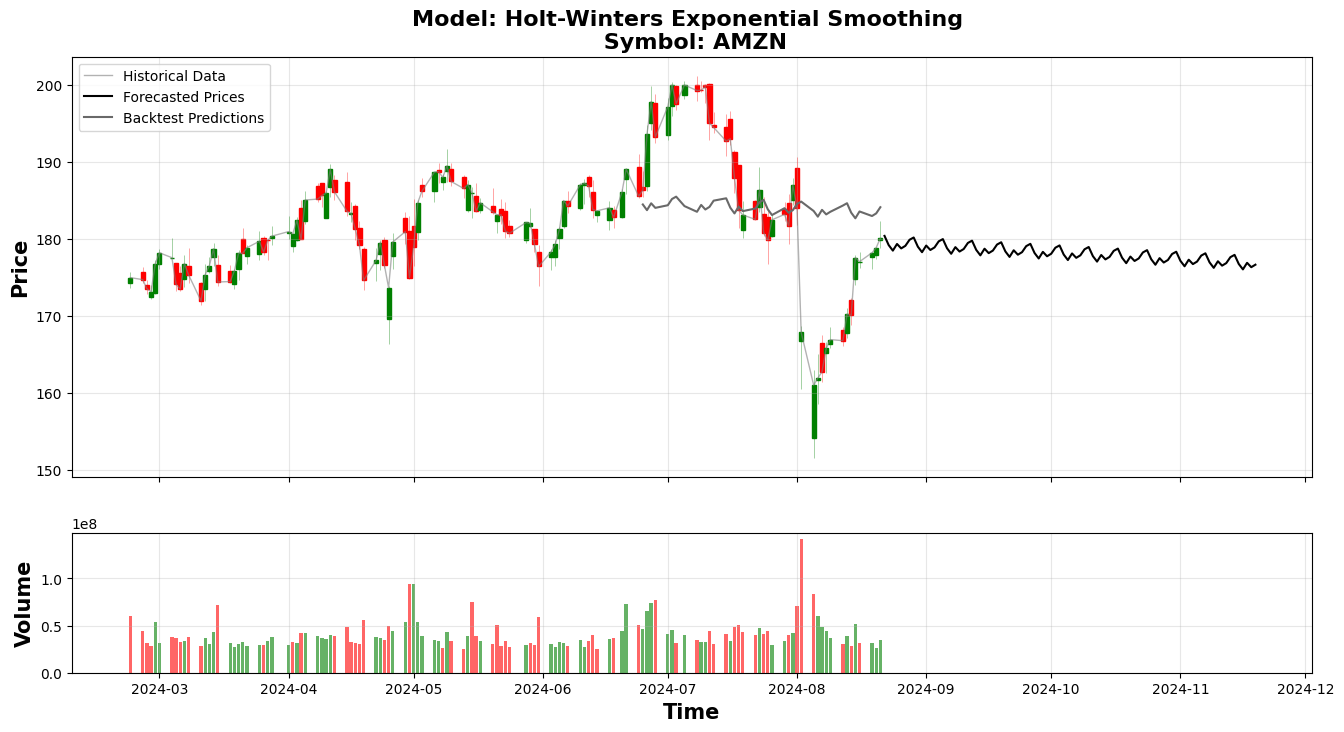

'iVBORw0KGgoAAAANSUhEUgAABkAAAAMgCAYAAAB7wK5aAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3xUVfrH8c8kk8lMOmkklJBQAgFCFRDYRVBEsKGiKDawrgULioo/RbH3VextF9h1FQtWVCwoRXoRSAQiLQRpIUAaKZPM3N8fMVcmjQTSSL5vX3nJvefcc88tM4H73HMei2EYBiIiIiIiIiIiIiIiIk2IV0N3QEREREREREREREREpLYpACIiIiIiIiIiIiIiIk2OAiAiIiIiIiIiIiIiItLkKAAiIiIiIiIiIiIiIiJNjgIgIiIiIiIiIiIiIiLS5CgAIiIiIiIiIiIiIiIiTY4CICIiIiIiIiIiIiIi0uQoACIiIiIiIiIiIiIiIk2OAiAiIiIiIiIiIiIiItLkKAAiIiIiIiIiIiIiIiJNjgIgIiIiIiIiIiIiIiLS5CgAIiIiIiIiIiIiIiIiTY4CICIiIiIiIiIiIiIi0uQoACIiIiIiIiIiIiIiIk2OAiAiIiIiIiIiIiIiItLkKAAiIiIiIiIiIiIiIiJNjgIgIiIiIiIiIiIiIiLS5CgAIiIiIiIiIiIiIiIiTY4CICIiIiIiIiIiIiIi0uQoACIiIiIiIiIiIiIiIk2OAiAiIiIiIiIiIiIiItLkKAAiIiIiIiIiIiIiIiJNjgIgIiIiIiIiIiIiIiLS5CgAIiIiIiIiIiIiIiIiTY4CICIiIiIiIiIiIiIi0uQoACIiIiIiIiIiIiIiIk2OAiAiIiIiIiIiIiIiItLkKAAiIiIiIiIiIiIiIiJNjgIgIiIiIiIiIiIiIiLS5CgAIiIiIiIiIiIiIiIiTY4CICIiIiIiIiIiIiIi0uQoACIiIiIiIiIiIiIiIk2OAiA

In [115]:
symbol = 'AMZN'
data_length = 180
forecast_days = 90
#Set start and end date
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol, start_date, end_date)
model = HWES_model(data, symbol)
model.train()
model.forecast(forecast_days)

### 2.5 ARCH Model

In [110]:
class ARCH_model(Model):
    def prepare_data(self, data):
        data = data.dropna()
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        if not data.index.freq:
            # Attempt to infer the frequency
            inferred_freq = pd.infer_freq(data.index)
            if inferred_freq:
                data.index.freq = inferred_freq
            else:
                # Handle the case where frequency cannot be inferred
                # For example, you might decide to use a default frequency or handle this as an exception
                print("Unable to infer frequency for the datetime index.")

        data.index.length = len(data)
        return data
    
    def __init__(self, data, symbol_name):
        #data = self.prepare_data(data)
        super().__init__(data = data['Close'], open = data['Open'], high = data['High'], low = data['Low'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Autoregressive Conditional Heteroskedasticity'
        self.stationary = False
        self.show_backtest = True

    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        self.stationary = p_value < alpha
        return self.stationary 

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def objective(self, trial):

        # Define range of parameters
        rescale = trial.suggest_categorical('rescale', [True, False])
        min_lag = 1
        max_lag = int(np.sqrt(len(self.data))) if len(self.data) >= 20 else len(self.data) // 2  # Ensure a practical upper bound for small datasets
        lags = trial.suggest_int('lags', min_lag, max_lag)
        p = trial.suggest_int('p', 1, 5)
        q = trial.suggest_int('q', 1, 5)
        vol = trial.suggest_categorical('vol', ['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 
                                                'APARCH', 'HARCH'])
        mean = trial.suggest_categorical('mean', ['Zero', 'LS', 'AR', 
                                                  'ARX', 'HAR', 'HARX'])
        mse_sum = 0
        n_splits = 2
        best_val_predictions = None
        best_val_index = None
        tscv = TimeSeriesSplit(n_splits=n_splits)
        warnings.filterwarnings("ignore")

        # Retrieve the current best_mse from user attributes
        best_mse = trial.user_attrs.get('best_mse', float('inf'))


        for train_index, val_index in tscv.split(self.data):
            train_split, val_split = self.data.iloc[train_index], self.data.iloc[val_index]
            try:
                model = arch_model(train_split, p = p, q = q, mean = mean, lags = lags, 
                                   rescale = rescale, vol = vol).fit(disp = 'off')
                predictions = model.forecast(horizon=len(val_split)).mean.values[-1, :]
                mse = mean_squared_error(val_split, predictions)
                mse_sum += mse
                # Store the predictions and index for the last validation split
                if len(val_index) > 0 and val_index[0] == len(self.data) - len(val_split):
                    best_val_predictions = predictions
                    best_val_index = val_index
            except Exception as e:
                print(e)
                return float('inf')  # Return a very low value if an error occurs

        avg_mse = mse_sum / n_splits
        if avg_mse<best_mse:
            # Store the best predictions and index within the trial object for later retrieval
            trial.set_user_attr("best_mse", avg_mse)
            trial.set_user_attr("best_val_predictions", best_val_predictions)
            trial.set_user_attr("best_val_index", best_val_index)

        return avg_mse
    
    def train(self):
            # Check stationarity and apply log transformation if needed
            if not self.check_stationarity(self.data):
                print("Series is not stationary. Applying log transformation...")
                self.data = self.log_transform(self.data)
                    
            # Create an Optuna study
            study = optuna.create_study(direction='minimize')

            # Define an initial best_mse as infinity
            initial_best_mse = float('inf')
            # Define the objective function with an initial best_mse
            def objective_with_initial_best_mse(trial):
                trial.set_user_attr("best_mse", initial_best_mse)
                return self.objective(trial)

            study.optimize(objective_with_initial_best_mse, n_trials=75)  # Number of trials can be adjusted

            best_params = study.best_params
            best_mse = study.best_value  # Access custom attributes returned from objective function

            # Retrieve the best trial
            best_trial = study.best_trial

            # Store the best validation predictions and index
            self.last_val_predictions = best_trial.user_attrs["best_val_predictions"]
            self.last_val_index = best_trial.user_attrs["best_val_index"]

            
            print(f"Best MSE score: {best_mse:.4f}")
            print(f"Best parameters: {best_params}")

            # Fit the best model on the entire dataset
            try:
                self.trained_model = arch_model(self.data, p = best_params['p'], q = best_params['q'], 
                                                mean = best_params['mean'],lags =  best_params['lags'],
                                                rescale =  best_params['rescale'], vol = best_params['vol']).fit(disp = 'off')
                print(f'Model training successful')
            except Exception as e:
                print(f'Model training failed with the error message: {e}')
            
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.forecast(horizon=forecast_days).mean.values[-1, :]
       # Reverse log transformation if applied
        if not self.stationary:
            self.data = np.exp(self.data)
            forecast_prices = np.exp(forecast_prices)
            if self.last_val_predictions is not None and self.last_val_index is not None:
                self.last_val_predictions = np.exp(self.last_val_predictions)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Create candlestick data
        candlestick_data = pd.DataFrame({
            'Date': self.data.index,
            'Open': self.open,
            'Close': self.data,
            'High': self.high,
            'Low': self.low
        })
        # Plot the candlestick data with decreased transparency
        for idx, row in candlestick_data.iterrows():
            date_num = mdates.date2num(row['Date'])
            if row['Close'] >= row['Open']:
                color = 'green'
                lower = row['Open']
                height = row['Close'] - row['Open']
            else:
                color = 'red'
                lower = row['Close']
                height = row['Open'] - row['Close']
            
            # Draw high and low lines (wicks) outside the rectangle
            ax1.vlines(date_num, row['Low'], lower, color=color, alpha=0.5, linewidth=0.5)
            ax1.vlines(date_num, lower + height, row['High'], color=color, alpha=0.5, linewidth=0.5)
            
            # Draw the rectangle (candlestick body)
            ax1.add_patch(mpatches.Rectangle((date_num - 0.5, lower), 1, height, edgecolor=color, facecolor=color, alpha=1, linewidth=1))
        
        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='gray', linewidth=1, alpha=0.6)
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='black', linewidth=1.5, linestyle = '-')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold', fontsize = 16)
        ax1.set_ylabel('Price', weight = 'bold', fontsize = 15)
        ax1.grid(True, alpha = 0.3)

        # Plot the last validation split predictions if available
        if self.show_backtest:
            if self.last_val_predictions is not None and self.last_val_index is not None:
                ax1.plot(self.data.index[self.last_val_index], self.last_val_predictions, label='Backtest Predictions', color='dimgray', linewidth=1.5, linestyle='-')

        ax1.legend(loc='upper left')
        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold', fontsize = 15)
        ax2.set_xlabel('Time', weight = 'bold', fontsize = 15)
        ax2.grid(True, alpha = 0.3)
        
        # Save plot to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plot_data = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        plt.show()
        #plt.close(fig)  # Close the plot to free up resources

        return plot_data

[*********************100%***********************]  1 of 1 completed

[I 2024-08-22 13:00:58,744] A new study created in memory with name: no-name-f003a96a-502e-403d-8448-e2e0e623050f
[I 2024-08-22 13:00:58,797] Trial 0 finished with value: inf and parameters: {'rescale': False, 'lags': 7, 'p': 1, 'q': 5, 'vol': 'EGARCH', 'mean': 'Constant'}. Best is trial 0 with value: inf.



Unable to infer frequency for the datetime index.
Series is not stationary. Applying log transformation...
Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:00:58,990] Trial 1 finished with value: 0.09347886453156486 and parameters: {'rescale': False, 'lags': 12, 'p': 2, 'q': 1, 'vol': 'ARCH', 'mean': 'HARX'}. Best is trial 1 with value: 0.09347886453156486.
[I 2024-08-22 13:00:58,996] Trial 2 finished with value: inf and parameters: {'rescale': True, 'lags': 23, 'p': 2, 'q': 4, 'vol': 'FIGARCH', 'mean': 'HAR'}. Best is trial 1 with value: 0.09347886453156486.
[I 2024-08-22 13:00:59,000] Trial 3 finished with value: inf and parameters: {'rescale': False, 'lags': 7, 'p': 4, 'q': 5, 'vol': 'FIGARCH', 'mean': 'ARX'}. Best is trial 1 with value: 0.09347886453156486.


p and q must be either 0 or 1.
p and q must be either 0 or 1.


[I 2024-08-22 13:00:59,281] Trial 4 finished with value: 0.09191107304236587 and parameters: {'rescale': False, 'lags': 19, 'p': 2, 'q': 3, 'vol': 'GARCH', 'mean': 'HARX'}. Best is trial 4 with value: 0.09191107304236587.
[I 2024-08-22 13:00:59,430] Trial 5 finished with value: 2028.6824856570884 and parameters: {'rescale': True, 'lags': 10, 'p': 4, 'q': 5, 'vol': 'ARCH', 'mean': 'Constant'}. Best is trial 4 with value: 0.09191107304236587.
[I 2024-08-22 13:00:59,586] Trial 6 finished with value: 0.14045594258752556 and parameters: {'rescale': False, 'lags': 27, 'p': 2, 'q': 1, 'vol': 'GARCH', 'mean': 'LS'}. Best is trial 4 with value: 0.09191107304236587.
[I 2024-08-22 13:00:59,682] Trial 7 finished with value: inf and parameters: {'rescale': False, 'lags': 9, 'p': 3, 'q': 2, 'vol': 'APARCH', 'mean': 'Zero'}. Best is trial 4 with value: 0.09191107304236587.
[I 2024-08-22 13:00:59,744] Trial 8 finished with value: inf and parameters: {'rescale': True, 'lags': 8, 'p': 4, 'q': 5, 'vol': 

Analytic forecasts not available for horizon > 1
Analytic forecasts not available for horizon > 1


/usr/local/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
[I 2024-08-22 13:00:59,960] Trial 9 finished with value: inf and parameters: {'rescale': True, 'lags': 12, 'p': 5, 'q': 4, 'vol': 'EGARCH', 'mean': 'HAR'}. Best is trial 4 with value: 0.09191107304236587.


Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:00,274] Trial 10 finished with value: 0.0935646285689447 and parameters: {'rescale': False, 'lags': 18, 'p': 1, 'q': 3, 'vol': 'GARCH', 'mean': 'HARX'}. Best is trial 4 with value: 0.09191107304236587.
[I 2024-08-22 13:01:00,651] Trial 11 finished with value: 0.09314946392344897 and parameters: {'rescale': False, 'lags': 18, 'p': 2, 'q': 1, 'vol': 'ARCH', 'mean': 'HARX'}. Best is trial 4 with value: 0.09191107304236587.
[I 2024-08-22 13:01:00,786] Trial 12 finished with value: 0.056309569931576195 and parameters: {'rescale': False, 'lags': 18, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'HARX'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:00,871] Trial 13 finished with value: 0.06929938341522607 and parameters: {'rescale': False, 'lags': 1, 'p': 3, 'q': 3, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:00,963] Trial 14 finished with value: 0.06929938341522607 and parameters: {'rescale': Fa

Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:02,701] Trial 20 finished with value: 0.07337128245838043 and parameters: {'rescale': False, 'lags': 20, 'p': 4, 'q': 3, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:02,811] Trial 21 finished with value: 0.06929938341522607 and parameters: {'rescale': False, 'lags': 1, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:02,891] Trial 22 finished with value: 0.06929938341522607 and parameters: {'rescale': False, 'lags': 1, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:02,994] Trial 23 finished with value: 0.07928914888782654 and parameters: {'rescale': False, 'lags': 4, 'p': 3, 'q': 3, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:03,082] Trial 24 finished with value: 0.07575686935651799 and parameters: {'rescale': False

p and q must be either 0 or 1.


/usr/local/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
[I 2024-08-22 13:01:03,837] Trial 28 finished with value: inf and parameters: {'rescale': False, 'lags': 16, 'p': 2, 'q': 2, 'vol': 'APARCH', 'mean': 'ARX'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:03,998] Trial 29 finished with value: inf and parameters: {'rescale': False, 'lags': 22, 'p': 1, 'q': 3, 'vol': 'EGARCH', 'mean': 'HAR'}. Best is trial 12 with value: 0.056309569931576195.


Analytic forecasts not available for horizon > 1
Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:04,097] Trial 30 finished with value: 0.1403769875056894 and parameters: {'rescale': False, 'lags': 10, 'p': 3, 'q': 1, 'vol': 'HARCH', 'mean': 'Constant'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:04,204] Trial 31 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 'lags': 2, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:04,314] Trial 32 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 'lags': 2, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:04,386] Trial 33 finished with value: 0.07364367565029842 and parameters: {'rescale': False, 'lags': 3, 'p': 3, 'q': 1, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:04,414] Trial 34 finished with value: inf and parameters: {'rescale': False, 'lags': 6

p and q must be either 0 or 1.


[I 2024-08-22 13:01:04,632] Trial 36 finished with value: 2027.8895518885604 and parameters: {'rescale': True, 'lags': 7, 'p': 2, 'q': 2, 'vol': 'ARCH', 'mean': 'LS'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:04,765] Trial 37 finished with value: 0.08413570740928111 and parameters: {'rescale': False, 'lags': 3, 'p': 4, 'q': 1, 'vol': 'ARCH', 'mean': 'HARX'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:05,206] Trial 38 finished with value: 0.08392227864482377 and parameters: {'rescale': False, 'lags': 26, 'p': 2, 'q': 4, 'vol': 'ARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:05,399] Trial 39 finished with value: 0.09108705098400288 and parameters: {'rescale': False, 'lags': 10, 'p': 4, 'q': 2, 'vol': 'ARCH', 'mean': 'HAR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:05,612] Trial 40 finished with value: 237155.83257540799 and parameters: {'rescale': True, 'l

p and q must be either 0 or 1.
Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:06,150] Trial 45 finished with value: 0.07760408993683393 and parameters: {'rescale': False, 'lags': 2, 'p': 3, 'q': 3, 'vol': 'GARCH', 'mean': 'HARX'}. Best is trial 12 with value: 0.056309569931576195.
/usr/local/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
[I 2024-08-22 13:01:06,917] Trial 46 finished with value: inf and parameters: {'rescale': False, 'lags': 17, 'p': 2, 'q': 4, 'vol': 'APARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:07,067] Trial 47 finished with value: 0.14011423398523584 and parameters: {'rescale': False, 'lags': 21, 'p': 4, 'q': 1, 'vol': 'HARCH', 'mean': 'Constant'}. Best is trial 12 with value: 0.056309569931576195.


Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:07,190] Trial 48 finished with value: 225050.62130838912 and parameters: {'rescale': True, 'lags': 2, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:07,282] Trial 49 finished with value: 23.95240259618501 and parameters: {'rescale': False, 'lags': 4, 'p': 3, 'q': 4, 'vol': 'ARCH', 'mean': 'Zero'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:07,391] Trial 50 finished with value: 0.0851354373018962 and parameters: {'rescale': False, 'lags': 12, 'p': 2, 'q': 3, 'vol': 'HARCH', 'mean': 'HARX'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:07,468] Trial 51 finished with value: 0.06929938341522607 and parameters: {'rescale': False, 'lags': 1, 'p': 3, 'q': 3, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:07,581] Trial 52 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 

Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:08,258] Trial 58 finished with value: 2027.7095047711366 and parameters: {'rescale': True, 'lags': 25, 'p': 3, 'q': 2, 'vol': 'GARCH', 'mean': 'LS'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:08,502] Trial 59 finished with value: 0.08629660264041222 and parameters: {'rescale': False, 'lags': 19, 'p': 4, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
/usr/local/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
[I 2024-08-22 13:01:08,964] Trial 60 finished with value: inf and parameters: {'rescale': False, 'lags': 1, 'p': 3, 'q': 3, 'vol': 'APARCH', 'mean': 'ARX'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:09,078] Trial 61 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 'lags': 2,

Analytic forecasts not available for horizon > 1


[I 2024-08-22 13:01:09,194] Trial 62 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 'lags': 2, 'p': 3, 'q': 5, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:09,294] Trial 63 finished with value: 0.07928914888782654 and parameters: {'rescale': False, 'lags': 4, 'p': 3, 'q': 4, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:09,396] Trial 64 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 'lags': 2, 'p': 3, 'q': 3, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:09,491] Trial 65 finished with value: 23.95240259618501 and parameters: {'rescale': False, 'lags': 5, 'p': 3, 'q': 5, 'vol': 'HARCH', 'mean': 'Zero'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:09,588] Trial 66 finished with value: 0.07320015252706405 and parameters: {'rescale': False,

p and q must be either 0 or 1.


[I 2024-08-22 13:01:09,854] Trial 68 finished with value: 0.07609451849846693 and parameters: {'rescale': False, 'lags': 14, 'p': 4, 'q': 2, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:10,026] Trial 69 finished with value: 0.1413149300883615 and parameters: {'rescale': False, 'lags': 3, 'p': 5, 'q': 3, 'vol': 'ARCH', 'mean': 'Constant'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:10,238] Trial 70 finished with value: 232656.14126628567 and parameters: {'rescale': True, 'lags': 8, 'p': 2, 'q': 4, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:10,348] Trial 71 finished with value: 0.06836638803150197 and parameters: {'rescale': False, 'lags': 2, 'p': 3, 'q': 5, 'vol': 'HARCH', 'mean': 'AR'}. Best is trial 12 with value: 0.056309569931576195.
[I 2024-08-22 13:01:10,456] Trial 72 finished with value: 0.06836638803150197 and parameters: {'rescale': Fal

Best MSE score: 0.0563
Best parameters: {'rescale': False, 'lags': 18, 'p': 3, 'q': 2, 'vol': 'HARCH', 'mean': 'HARX'}
Model training successful


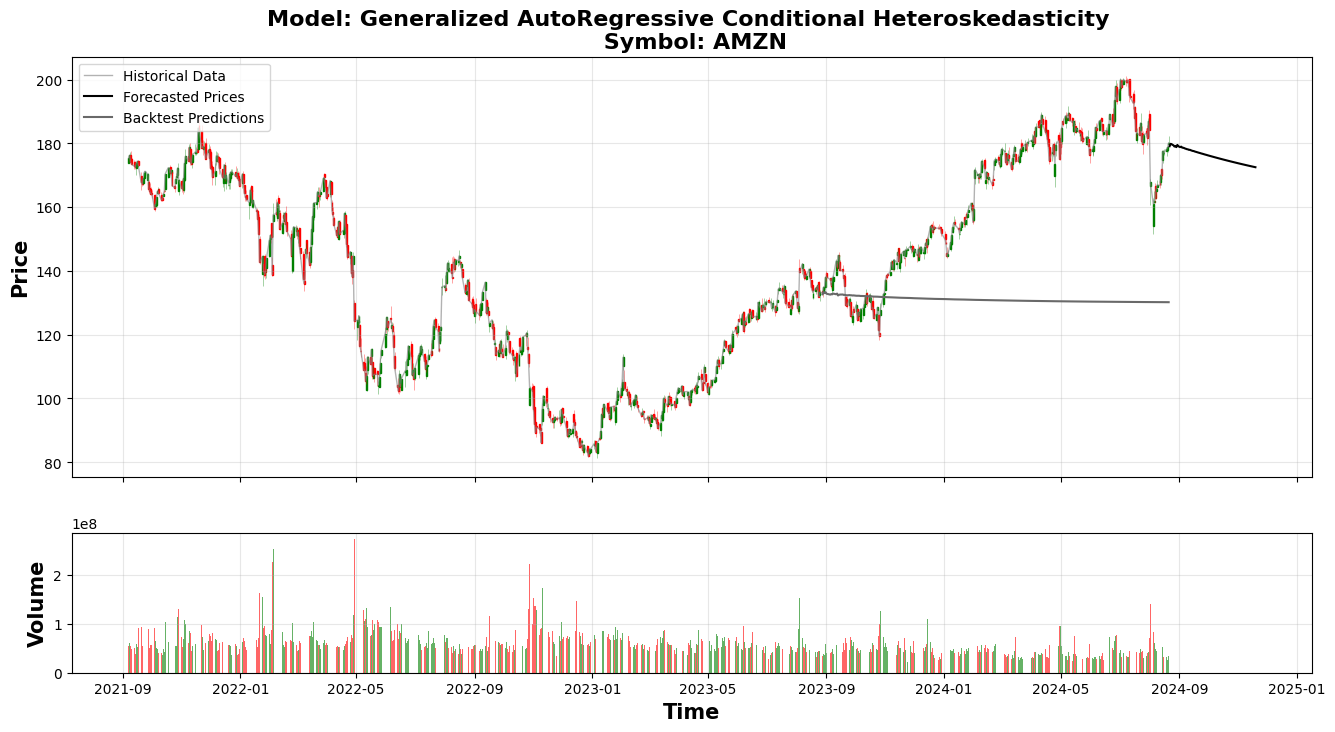

'iVBORw0KGgoAAAANSUhEUgAABkAAAAMgCAYAAAB7wK5aAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3wURR8G8Of6pYckpBGSAEmoAelNIfQiRbqAUgULXZGiIKAiiihNBF9QQBFBKVKlSpHQUSAhoZdQQhqk55Ir+/4Rs2ZzqaTB8Xz93Ed2Z2dndmezl+xvZ0YmCIIAIiIiIiIiIiIiIiIiCyIv7woQERERERERERERERGVNAZAiIiIiIiIiIiIiIjI4jAAQkREREREREREREREFocBECIiIiIiIiIiIiIisjgMgBARERERERERERERkcVhAISIiIiIiIiIiIiIiCwOAyBERERERERERERERGRxGAAhIiIiIiIiIiIiIiKLwwAIERERERERERERERFZHAZAiIiIiIiIiIiIiIjI4jAAQkREREREREREREREFocBECIiIiIiIiIiIiIisjgMgBARERERERERERERkcVhAISIiIiIiIiIiIiIiCwOAyBERERERERERERERGRxGAAhIiIiIiIiIiIiIiKLwwAIERERERERERERERFZHAZAiIiIiIiIiIiIiIjI4jAAQkREREREREREREREFocBECIiIiIiIiIiIiIisjgMgBARERERERERERERkcVhAISIiIiIiIiIiIiIiCwOAyBERERERERERERERGRxGAAhIiIiIiIiIiIiIiKLwwAIERERERERERERERFZHAZAiIiIiIiIiIiIiIjI4jAAQkREREREREREREREFocBECIiIiIiIiIiIiIisjgMgBARERERERERERERkcVhAISIiIiIiIiIiIiIiCwOAyBERERERERERERERGRxGAAhIiIiIiIiIiIiIiKLwwAIERERERERERERERF

In [111]:
symbol = 'AMZN'
data_length = 1080
forecast_days = 90
#Set start and end date
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol, start_date, end_date)
model = GARCH_model(data, symbol)
model.train()
model.forecast(forecast_days)

### 2.6 UCM Model

In [105]:
class UCM_model(Model):
    def prepare_data(self, data):
        data = data.dropna()
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        if not data.index.freq:
            # Attempt to infer the frequency
            inferred_freq = pd.infer_freq(data.index)
            if inferred_freq:
                data.index.freq = inferred_freq
            else:
                # Handle the case where frequency cannot be inferred
                # For example, you might decide to use a default frequency or handle this as an exception
                print("Unable to infer frequency for the datetime index.")

        data.index.length = len(data)
        return data
    
    def __init__(self, data, symbol_name):
        data = self.prepare_data(data)
        super().__init__(data = data['Close'], open = data['Open'], high = data['High'], low = data['Low'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Unobserved Components Model'
        self.stationary = False
        self.show_backtest = True

    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        self.stationary = p_value < alpha
        return self.stationary 

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def objective(self, trial):

        # Define range of parameters
        level = trial.suggest_categorical('level', [True, False])
        trend = trial.suggest_categorical('trend', [True, False])
        seasonal = trial.suggest_categorical('seasonal', [7, 12, 30, 52]) 
        cycle = trial.suggest_categorical('cycle', [True, False])  
        damped_cycle = trial.suggest_categorical('damped_cycle', [True, False]) 
        irregular = trial.suggest_categorical('irregular', [True, False])  
        autoregressive = trial.suggest_int('autoregressive', 1, 10)

        mse_sum = 0
        n_splits = 2
        best_val_predictions = None
        best_val_index = None
        tscv = TimeSeriesSplit(n_splits=n_splits)
        warnings.filterwarnings("ignore")

        # Retrieve the current best_mse from user attributes
        best_mse = trial.user_attrs.get('best_mse', float('inf'))


        for train_index, val_index in tscv.split(self.data):
            train_split, val_split = self.data.iloc[train_index], self.data.iloc[val_index]
            try:
                model = UnobservedComponents(train_split, level = level, trend = trend, seasonal = seasonal, cycle = cycle, 
                                             damped_cycle = damped_cycle, irregular = irregular, autoregressive = autoregressive).fit(disp = False)
                predictions = model.get_forecast(steps=len(val_split)).predicted_mean
                mse = mean_squared_error(val_split, predictions)
                mse_sum += mse
                # Store the predictions and index for the last validation split
                if len(val_index) > 0 and val_index[0] == len(self.data) - len(val_split):
                    best_val_predictions = predictions
                    best_val_index = val_index
            except Exception as e:
                print(e)
                return float('inf')  # Return a very low value if an error occurs

        avg_mse = mse_sum / n_splits
        if avg_mse<best_mse:
            # Store the best predictions and index within the trial object for later retrieval
            trial.set_user_attr("best_mse", avg_mse)
            trial.set_user_attr("best_val_predictions", best_val_predictions)
            trial.set_user_attr("best_val_index", best_val_index)

        return avg_mse
    
    def train(self):
            # Check stationarity and apply log transformation if needed
            if not self.check_stationarity(self.data):
                print("Series is not stationary. Applying log transformation...")
                self.data = self.log_transform(self.data)
                    
            # Create an Optuna study
            study = optuna.create_study(direction='minimize')

            # Define an initial best_mse as infinity
            initial_best_mse = float('inf')
            # Define the objective function with an initial best_mse
            def objective_with_initial_best_mse(trial):
                trial.set_user_attr("best_mse", initial_best_mse)
                return self.objective(trial)

            study.optimize(objective_with_initial_best_mse, n_trials=30)  # Number of trials can be adjusted

            best_params = study.best_params
            best_mse = study.best_value  # Access custom attributes returned from objective function

            # Retrieve the best trial
            best_trial = study.best_trial

            # Store the best validation predictions and index
            self.last_val_predictions = best_trial.user_attrs["best_val_predictions"]
            self.last_val_index = best_trial.user_attrs["best_val_index"]

            
            print(f"Best MSE score: {best_mse:.4f}")
            print(f"Best parameters: {best_params}")

            # Fit the best model on the entire dataset
            try:
                self.trained_model =  UnobservedComponents(self.data, level = best_params['level'], trend = best_params['trend'], seasonal = best_params['seasonal'], 
                                                           cycle = best_params['cycle'], damped_cycle = best_params['damped_cycle'], irregular = best_params['irregular'],
                                                           autoregressive = best_params['autoregressive']).fit(disp = False)
                print(f'Model training successful')
            except Exception as e:
                print(f'Model training failed with the error message: {e}')
            
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.get_forecast(steps=forecast_days).predicted_mean
       # Reverse log transformation if applied
        if not self.stationary:
            self.data = np.exp(self.data)
            forecast_prices = np.exp(forecast_prices)
            if self.last_val_predictions is not None and self.last_val_index is not None:
                self.last_val_predictions = np.exp(self.last_val_predictions)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Create candlestick data
        candlestick_data = pd.DataFrame({
            'Date': self.data.index,
            'Open': self.open,
            'Close': self.data,
            'High': self.high,
            'Low': self.low
        })
        # Plot the candlestick data with decreased transparency
        for idx, row in candlestick_data.iterrows():
            date_num = mdates.date2num(row['Date'])
            if row['Close'] >= row['Open']:
                color = 'green'
                lower = row['Open']
                height = row['Close'] - row['Open']
            else:
                color = 'red'
                lower = row['Close']
                height = row['Open'] - row['Close']
            
            # Draw high and low lines (wicks) outside the rectangle
            ax1.vlines(date_num, row['Low'], lower, color=color, alpha=0.5, linewidth=0.5)
            ax1.vlines(date_num, lower + height, row['High'], color=color, alpha=0.5, linewidth=0.5)
            
            # Draw the rectangle (candlestick body)
            ax1.add_patch(mpatches.Rectangle((date_num - 0.5, lower), 1, height, edgecolor=color, facecolor=color, alpha=1, linewidth=1))
        
        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='gray', linewidth=1, alpha=0.6)
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='black', linewidth=1.5, linestyle = '-')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold', fontsize = 16)
        ax1.set_ylabel('Price', weight = 'bold', fontsize = 15)
        ax1.grid(True, alpha = 0.3)

        # Plot the last validation split predictions if available
        if self.show_backtest:
            if self.last_val_predictions is not None and self.last_val_index is not None:
                ax1.plot(self.data.index[self.last_val_index], self.last_val_predictions, label='Backtest Predictions', color='dimgray', linewidth=1.5, linestyle='-')

        ax1.legend(loc='upper left')
        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold', fontsize = 15)
        ax2.set_xlabel('Time', weight = 'bold', fontsize = 15)
        ax2.grid(True, alpha = 0.3)
        
        # Save plot to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plot_data = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        plt.show()
        #plt.close(fig)  # Close the plot to free up resources

        return plot_data

[*********************100%***********************]  1 of 1 completed

[I 2024-08-22 12:54:45,089] A new study created in memory with name: no-name-84467c5b-b0a0-4068-b50b-979a2829d056



Unable to infer frequency for the datetime index.
Series is not stationary. Applying log transformation...


[I 2024-08-22 12:54:48,064] Trial 0 finished with value: 0.14480428500832737 and parameters: {'level': False, 'trend': True, 'seasonal': 7, 'cycle': False, 'damped_trend': True, 'irregular': True, 'autoregressive': 8}. Best is trial 0 with value: 0.14480428500832737.
[I 2024-08-22 12:54:51,104] Trial 1 finished with value: 0.45785519637157157 and parameters: {'level': True, 'trend': False, 'seasonal': 7, 'cycle': False, 'damped_trend': False, 'irregular': False, 'autoregressive': 8}. Best is trial 0 with value: 0.14480428500832737.
[I 2024-08-22 12:54:51,440] Trial 2 finished with value: inf and parameters: {'level': False, 'trend': False, 'seasonal': 7, 'cycle': True, 'damped_trend': False, 'irregular': True, 'autoregressive': 9}. Best is trial 0 with value: 0.14480428500832737.


Schur decomposition solver error.


[I 2024-08-22 12:54:55,426] Trial 3 finished with value: 0.5448494228900046 and parameters: {'level': True, 'trend': False, 'seasonal': 7, 'cycle': False, 'damped_trend': False, 'irregular': True, 'autoregressive': 8}. Best is trial 0 with value: 0.14480428500832737.
[I 2024-08-22 12:54:57,176] Trial 4 finished with value: 0.08479479858649312 and parameters: {'level': False, 'trend': True, 'seasonal': 7, 'cycle': True, 'damped_trend': False, 'irregular': False, 'autoregressive': 3}. Best is trial 4 with value: 0.08479479858649312.
[I 2024-08-22 12:55:17,593] Trial 5 finished with value: 0.13607098461722206 and parameters: {'level': True, 'trend': True, 'seasonal': 30, 'cycle': True, 'damped_trend': False, 'irregular': False, 'autoregressive': 10}. Best is trial 4 with value: 0.08479479858649312.
[I 2024-08-22 12:55:46,607] Trial 6 finished with value: 0.10954055175016605 and parameters: {'level': True, 'trend': True, 'seasonal': 52, 'cycle': False, 'damped_trend': False, 'irregular': T

Schur decomposition solver error.


[I 2024-08-22 12:55:49,484] Trial 8 finished with value: 0.5278536088268646 and parameters: {'level': True, 'trend': False, 'seasonal': 12, 'cycle': False, 'damped_trend': True, 'irregular': True, 'autoregressive': 5}. Best is trial 4 with value: 0.08479479858649312.
[I 2024-08-22 12:55:51,334] Trial 9 finished with value: 0.20881119942510268 and parameters: {'level': True, 'trend': True, 'seasonal': 12, 'cycle': True, 'damped_trend': False, 'irregular': True, 'autoregressive': 2}. Best is trial 4 with value: 0.08479479858649312.
[I 2024-08-22 12:55:55,179] Trial 10 finished with value: 0.05464748987068012 and parameters: {'level': False, 'trend': True, 'seasonal': 30, 'cycle': True, 'damped_trend': True, 'irregular': False, 'autoregressive': 1}. Best is trial 10 with value: 0.05464748987068012.
[I 2024-08-22 12:55:59,082] Trial 11 finished with value: 0.05464748987068012 and parameters: {'level': False, 'trend': True, 'seasonal': 30, 'cycle': True, 'damped_trend': True, 'irregular': F

Schur decomposition solver error.


[I 2024-08-22 12:57:28,821] Trial 27 finished with value: 0.09880695076936905 and parameters: {'level': False, 'trend': True, 'seasonal': 30, 'cycle': True, 'damped_trend': True, 'irregular': False, 'autoregressive': 2}. Best is trial 10 with value: 0.05464748987068012.
[I 2024-08-22 12:57:50,162] Trial 28 finished with value: 0.12383714381098841 and parameters: {'level': False, 'trend': True, 'seasonal': 52, 'cycle': True, 'damped_trend': True, 'irregular': False, 'autoregressive': 4}. Best is trial 10 with value: 0.05464748987068012.
[I 2024-08-22 12:57:53,322] Trial 29 finished with value: 0.13437779587870635 and parameters: {'level': False, 'trend': True, 'seasonal': 12, 'cycle': False, 'damped_trend': True, 'irregular': False, 'autoregressive': 7}. Best is trial 10 with value: 0.05464748987068012.


Best MSE score: 0.0546
Best parameters: {'level': False, 'trend': True, 'seasonal': 30, 'cycle': True, 'damped_trend': True, 'irregular': False, 'autoregressive': 1}
Model training successful


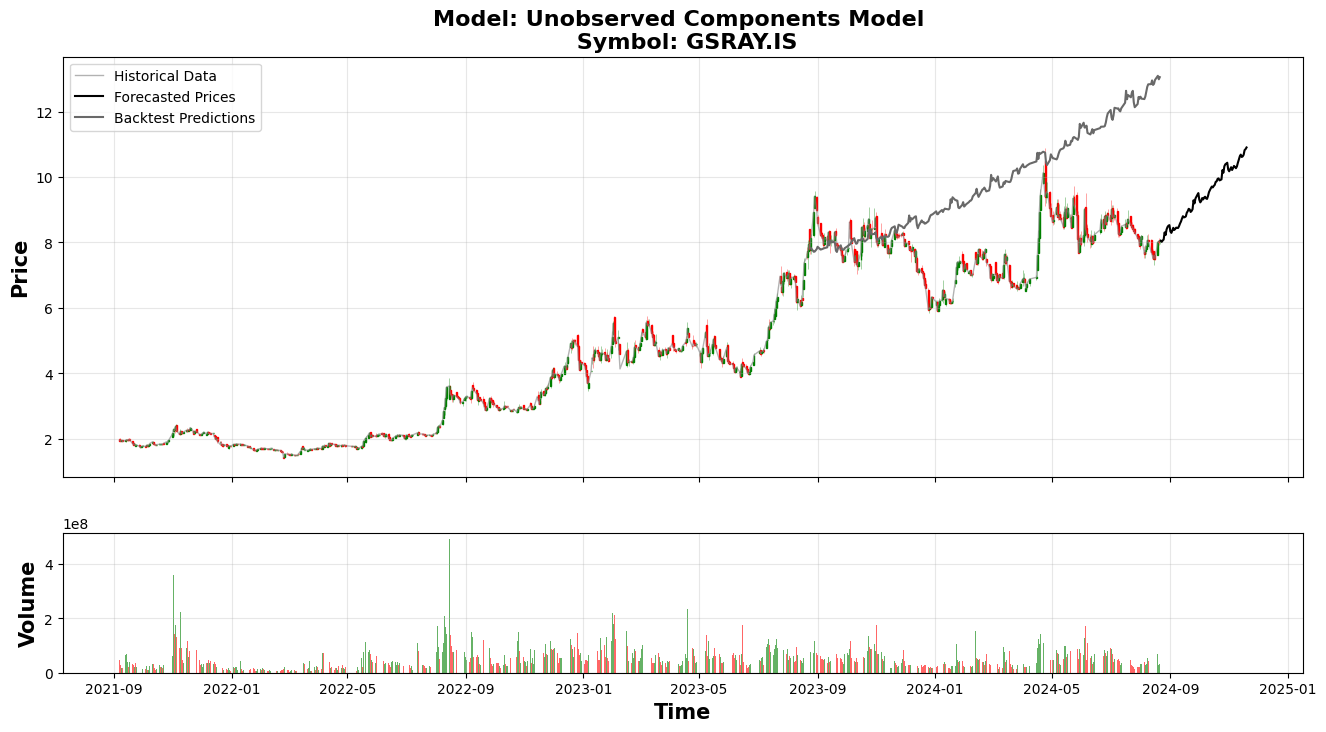

'iVBORw0KGgoAAAANSUhEUgAABkAAAAMgCAYAAAB7wK5aAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd1gUV9sG8Hth6VXpHVRQUcHeC9h7L7HEEqPJa0wssSb2RKOJiSVGk2jEkmKPsZeoaMQSuyBYQBALRVF6353vDz4mDAsIUhbW+3dde2VnzpyZZ+bMLmaePefIBEEQQEREREREREREREREpEG01B0AERERERERERERERFRWWMChIiIiIiIiIiIiIiINA4TIEREREREREREREREpHGYACEiIiIiIiIiIiIiIo3DBAgREREREREREREREWkcJkCIiIiIiIiIiIiIiEjjMAFCREREREREREREREQahwkQIiIiIiIiIiIiIiLSOEyAEBERERERERERERGRxmEChIiIiIiIiIiIiIiINA4TIEREREREREREREREpHGYACEiIiIiIiIiIiIiIo3DBAgREREREREREREREWkcJkCIiIiIiIiIiIiIiEjjMAFCREREREREREREREQahwkQIiIiIiIiIiIiIiLSOEyAEBERERERERERERGRxmEChIiIiIiIiIiIiIiINA4TIEREREREREREREREpHGYACEiIiIiIiIiIiIiIo3DBAgREREREREREREREWkcJkCIiIiIiIiIiIiIiEjjMAFCREREREREREREREQahwkQIiIiIiIiIiIiIiLSOEyAEBERERERERERERGRxmEChIiIiIiIiIiIiIiINA4TIEREREREREREREREpHGYACEiIiIiIiIiIiIiIo3DBAgREREREREREREREWkcJkCIiIiIiIiIiIiIiEjjMAFCREREREREREREREQahwkQIiIiIiIiIiIiIiLSOEyAEBERERERERERERG

In [107]:
symbol = 'GSRAY.IS'
data_length = 1080
forecast_days = 90
#Set start and end date
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol, start_date, end_date)
model = UCM_model(data, symbol)
model.train()
model.forecast(forecast_days)

### Model Creation Method

In [6]:
def create_model(model_type, data, symbol_name):
    if model_type == 'AR':
        return AR_model(data, symbol_name)

## 3. Database for User and Model Tables

### 3.1 Users Table

In [7]:
class User(db.Model):
    id = db.Column(db.Integer, primary_key=True, autoincrement=True)
    email = db.Column(db.String(120), unique=True, nullable=False)
    password = db.Column(db.String(255), nullable=False)
    account_type = db.Column(db.String(20), nullable=False)  # 'basic' or 'premium'
    symbols = db.relationship('Symbol', backref='user', lazy=True)

    def __repr__(self):
        return f'<User: {self.email} - Account Type: {self.account_type}>'

### 3.2 Symbols Table

In [8]:
class Symbol(db.Model):
    id = db.Column(db.Integer, primary_key=True, autoincrement=True)
    name = db.Column(db.String(50), nullable=False, unique=False)
    user_id = db.Column(db.Integer, db.ForeignKey('user.id'), nullable=False)

    def __repr__(self):
        return f'<Symbol: {self.name}>'

### 3.3 Trained Models Table

In [9]:
class TrainedModels(db.Model):
    id = db.Column(db.Integer, primary_key=True, autoincrement=True)
    symbol = db.Column(db.String(20), nullable=False)
    model_type = db.Column(db.String(50), nullable=False)
    start_date = db.Column(db.String(50), nullable=False)
    end_date = db.Column(db.String(50), nullable=False)  # Nullable if model is ongoing
    model_obj = db.Column(db.Text)  # Serialized model data or file path

    def __repr__(self):
        return f'<Model: {self.model_type} - Symbol: {self.symbol} - Start Date: {self.start_date} - End Date: {self.end_date}>'

    def save_trained_model(self, model_obj):
        """
        Save the trained model to the database.
        """
        self.model_obj = pickle.dumps(model_obj)
        db.session.add(self)
        db.session.commit()
    
    @classmethod
    def load_trained_model(self, model_type, start_date, end_date, symbol):
        model_entry = TrainedModels.query.filter_by(
                        model_type=model_type,
                        start_date=start_date,
                        end_date=end_date,
                        symbol=symbol
                    ).first()
        if model_entry:
            return pickle.loads(model_entry.model_obj)
        else:
            return None
    @classmethod
    def delete_all_models(self):
        try:
            # Delete all entries from the TrainedModels table
            TrainedModels.query.delete()
            db.session.commit()
            print("All models are deleted successfully.")
        except Exception as e:
            db.session.rollback()
            print(f"Error occurred: {str(e)}")


### 3.4 Temporary Password

In [10]:
class TemporaryPassword(db.Model):
    email = db.Column(db.String(120), primary_key=True, nullable=False)
    temp_password = db.Column(db.String(255), nullable=False)

## 4. PAGES

In [11]:
@app.route('/')
def index():
    return render_template('login.html')

### 4.1 Login 

In [12]:
@app.route('/login', methods=['GET', 'POST'])
def login():

    if request.method == 'GET':
        # Serve the signup and forgot password page
        return render_template('login.html')
    
    if request.method == 'POST':
        data = request.json
        email = data.get('email')
        password = data.get('password')
        
        user = User.query.filter_by(email=email).first()

        if user and check_password_hash(user.password, password):
            # Store user ID in session
            session['user_id'] = user.id
            session['email'] = user.email  # Store the email in the session
            return jsonify({'message': 'Login successful!', 'redirect': url_for('main')}), 200
        else:
            return jsonify({'message': 'Invalid credentials'}), 401

### 4.2 Signup

In [13]:
def is_valid_password(password):
    """Check if the password is valid based on the criteria."""
    if len(password) < 8: # Check password length
        return False
    if not re.search(r'[A-Z]', password):  # Check for uppercase letter
        return False
    if not re.search(r'[a-z]', password):  # Check for lowercase letter
        return False
    if not re.search(r'[0-9]', password):  # Check for number
        return False
    return True

In [14]:
@app.route('/signup', methods=['GET', 'POST'])
def signup():
    if request.method == 'GET':
        # Serve the signup page
        return render_template('signup.html')
    
    if request.method == 'POST':
        data = request.json
        if not data:
            return jsonify({'message': 'No data provided'}), 400
        
        email = data.get('email')
        password = data.get('password')
        password_re = data.get('password_re')
        
        # Check if all fields are present
        if not email or not password or not password_re:
            return jsonify({'message': 'All fields are required.'}), 400

        # Check if email already exists
        existing_user = User.query.filter_by(email=email).first()
        if existing_user:
            return jsonify({'message': 'User already exists.'}), 400

        # Check if passwords match
        if password != password_re:
            return jsonify({'message': 'Passwords do not match.'}), 400
        
        # Validate password strength
        if not is_valid_password(password):
            return jsonify({'message': 'Password must be at least 8 characters long, include uppercase letters, lowercase letters, and numbers.'}), 400
        
        # Create new user
        hashed_password = generate_password_hash(password, method='pbkdf2:sha256')

        # Creating an empty list of symbols for the new user is implicit because we start with no symbols related to the user
        new_user = User(email=email, password=hashed_password, account_type='basic')
        try:
            db.session.add(new_user)
            db.session.commit()
            return jsonify({'message': 'Sign-up successful!', 'redirect': url_for('login')}), 200
        except Exception as e:
            return jsonify({'message': 'Error creating user.'}), 500


### 4.3 Request E-mail

In [15]:
def generate_temporary_password(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

def send_email(email, temporary_password):
    # Placeholder function to simulate sending an email
    # Implement actual email sending logic here
    print(f"Sending temporary password to {email}: {temporary_password}")

In [16]:
@app.route('/request_email', methods=['GET', 'POST'])
def request_email():
    if request.method == 'POST':
        data = request.get_json()
        email = data.get('email')
        
        # Check if the email exists in the User database
        user = User.query.filter_by(email=email).first()
        if user:  
            # Generate a temporary password
            temp_password = generate_temporary_password()
            # Check if a temporary password entry already exists for the email
            temp_password_entry = TemporaryPassword.query.filter_by(email=email).first()
            if temp_password_entry:
                db.session.delete(temp_password_entry)
                db.session.commit()

            temp_password_entry = TemporaryPassword(email=email, temp_password=temp_password)
            db.session.add(temp_password_entry)
            db.session.commit()
            
            # Send a temporary password
            send_email(email, temp_password)

            # Store the email in a session to use in forgot password section
            session['resetEmail'] = email
            
            return jsonify({'success': True, 'message': 'Temporary password sent to your email'})
        else:
            return jsonify({'success': False, 'message': 'Email not found'})

    return render_template('request_email.html')


### 4.4 Forgot Passward

In [17]:
@app.route('/forgot_password', methods=['GET', 'POST'])
def forgot_password():
    if request.method == 'POST':
        data = request.get_json()
        temp_password = data.get('tempPassword')
        
        #Retrieve email from session
        email = session.get('resetEmail')

        if not email:
            return jsonify({'success': False, 'message': 'No email found in session. Please request an email first.'})

        # Check the temporary password in the database
        temp_password_entry = TemporaryPassword.query.filter_by(email=email, temp_password=temp_password).first()
        if temp_password_entry:
            # Temporary password matches
            return jsonify({'success': True, 'message': 'Temporary password verified. Proceed to reset password.'})
        else:
            return jsonify({'success': False, 'message': 'Invalid temporary password'})

    return render_template('forgot_password.html')

### 4.5 Reset Password

In [18]:
@app.route('/reset_password', methods=['GET', 'POST'])
def reset_password():
    if request.method == 'POST':
        data = request.get_json()
        new_password = data.get('newPassword')
        new_password_re = data.get('newPassword_re')

        # Retrieve the email from session
        email = session.get('resetEmail')

        if not email:
            return jsonify({'success': False, 'message': 'No email found in session. Please request an email first.'})

        if new_password != new_password_re:
            return jsonify({'success': False, 'message': 'Passwords do not match'})
        
        # Validate password strength
        if not is_valid_password(new_password):
            return jsonify({'message': 'Password must be at least 8 characters long, include uppercase letters, lowercase letters, and numbers.'}), 400

        # Fetch the user from the database
        user = User.query.filter_by(email=email).first()
        if user:
            # Check if the new password is different from the current password
            if check_password_hash(user.password, new_password):
                return jsonify({'success': False, 'message': 'New password must be different from the old password'})
            
            # Update the password
            hashed_new_password = generate_password_hash(new_password, method='pbkdf2:sha256')
            user.password = hashed_new_password
            db.session.commit()
            return jsonify({'success': True, 'message': 'Password successfully updated. You can now login with your new password.'})
        else:
            return jsonify({'success': False, 'message': 'User not found'})

    # Ensure session email is set, otherwise redirect to request_email
    if not session.get('resetEmail'):
        return jsonify({'redirect': '/request_email', 'message': 'No email found in session. Please request an email first.'})

    return render_template('reset_password.html')

### 4.6 Main 

In [19]:
@app.route('/forecaster', methods=['GET', 'POST']) # Forecaster Button 
def main():
    # Data fetching
    return render_template('main.html')

In [20]:
@app.route('/logout', methods=['GET', 'POST']) # Logout Button
def logout():
    # Perform logout operations if needed
    return redirect(url_for('login'))

In [21]:
@app.route('/my_profile', methods=['GET'])
def my_profile():
    user_id = session['user_id']
    user = User.query.get(user_id)  # Fetch the user by ID
    
    return render_template('my_profile.html', user=user)

In [22]:
@app.route('/about_models', methods=['GET', 'POST']) # About Models Button
def about_models():
    return render_template('about_models.html')

In [23]:
@app.route('/get_symbols', methods=['GET']) # Getter method to fetch symbols from the users account
def get_symbols():
    user_id = session.get('user_id')
    if not user_id:
        return jsonify({'success': False, 'message': 'User not logged in'}), 401

    symbols = Symbol.query.filter_by(user_id=user_id).all()
    symbol_list = [symbol.name for symbol in symbols]

    return jsonify({'symbols': symbol_list}), 200

In [13]:
def fetch_data(symbol, start_date, end_date): # fetch data based on user preference
    data = None
    try:
        # Fetch historical price data
        df = yf.download(symbol, start=start_date, end=end_date)

        # Drop 'Adj Close' column if present
        if 'Adj Close' in df.columns:
            df.drop(columns=['Adj Close'], inplace=True)

        # Store the dataframe with technical indicators
        data = df

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

    return data

def check_symbol_existence(symbol): #check the existence of symbol from yahoo finance
    try:
        stock = yf.Ticker(symbol)
        data = stock.history(period="1d")
        return not data.empty
    except Exception as e:
        print(f"Error fetching data for symbol {symbol}: {e}")
        return False

In [25]:
def convert_to_days(input_length):
    days = 0
    if input_length == '1_week':
        days = 7
    elif input_length == '1_month':
        days = 30
    elif input_length == '2_months':
        days = 60
    elif input_length == '3_months':
        days = 90
    elif input_length == '4_months':
        days = 120
    elif input_length == '5_months':
        days = 150
    elif input_length == '6_months':
        days = 180
    elif input_length == '9_months':
        days = 270
    elif input_length == '1_year':
        days = 360
    elif input_length == '2_years':
        days = 720
    elif input_length == '3_years':
        days = 1080
    elif input_length == '4_years':
        days = 1440
    elif input_length == '5_years':
        days = 1800
        
    return days

In [26]:
@app.route('/add_symbol', methods=['POST'])
def add_symbol(): # add symbol to the db
    user_id = session.get('user_id')
    if not user_id:
        return jsonify({'success': False, 'message': 'User not logged in'}), 401

    data = request.json
    symbol_name = data.get('symbol')
    if not symbol_name:
        return jsonify({'success': False, 'message': 'Symbol name not provided'}), 400

    if not check_symbol_existence(symbol_name):
        return jsonify({'success': False, 'message': 'Symbol does not exist'}), 404

    existing_symbol = Symbol.query.filter_by(name=symbol_name, user_id=user_id).first()
    if existing_symbol:
        return jsonify({'success': False, 'message': 'Symbol already added'}), 400
    
    new_symbol = Symbol(name=symbol_name, user_id=user_id)
    db.session.add(new_symbol)
    db.session.commit()

    return jsonify({'success': True}), 200

In [27]:
@app.route('/delete_symbol', methods=['POST'])
def delete_symbol(): # delete symbol from the db
    data = request.json
    if not data or 'symbol' not in data:
        return jsonify({'message': 'Invalid request'}), 400

    symbol_name = data['symbol']
    user_id = session.get('user_id')

    # Find and delete the symbol
    symbol = Symbol.query.filter_by(name=symbol_name, user_id=user_id).first()
    if symbol:
        db.session.delete(symbol)
        db.session.commit()
        return jsonify({'success': True}), 200
    else:
        return jsonify({'message': 'Symbol not found'}), 404

In [28]:
@app.route('/predict', methods=['GET', 'POST'])
def predict(): # predict button
    try:
        data = request.json
        symbol = data['symbol']
        data_length = convert_to_days(data['data_length'])
        forecast_days = convert_to_days(data['forecast_days'])
        model_type = data['model_type']
        #Set start and end date
        now = datetime.now()
        start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
        end_date = now.strftime("%Y-%m-%d")

        #Check if model already exists
        model_obj = TrainedModels.load_trained_model(model_type=model_type, start_date=start_date, end_date=end_date, symbol=symbol)
        if not model_obj:  # if the model is already trained avoid re-training it.
            data = fetch_data(symbol, start_date, end_date)
            model_obj = create_model(model_type, data, symbol)
            model_obj.train()
            # Create a new instance of Model
            new_model = TrainedModels(symbol= symbol, model_type= model_type, start_date= start_date, end_date= end_date)
            # Save the trained model to the database
            new_model.save_trained_model(model_obj)
        
        # Forecast
        plot_data = model_obj.forecast(forecast_days=forecast_days)
        return jsonify({'plot': plot_data}), 200

    except KeyError as e:
        return jsonify({'error': f'Missing key: {e.args[0]}'}, 400)

    except Exception as e:
        return jsonify({'error': str(e)}, 500)

### 4.7 My Profile

In [29]:
@app.route('/delete_account', methods=['POST'])
def delete_account():
    if 'user_id' not in session:
        #flash('You need to log in first.', 'warning')
        return redirect(url_for('login'))

    user_id = session['user_id']
    user = User.query.get(user_id)  # Fetch user by ID
    if user:
        # Step 1: Delete all symbols associated with the user
        Symbol.query.filter_by(user_id=user.id).delete()

        # Step 2: Delete the user from the User table
        db.session.delete(user)

        # Step 3: Commit the transaction to apply changes to the database
        db.session.commit()

        # Step 4: Remove the user from the session since the account is deleted
        session.pop('user_id', None)
        session.pop('email', None)  # Clean up the email as well

        #flash('Your account has been deleted successfully.', 'success')
        return redirect(url_for('login'))  # Redirect to login page
    else:
        #flash('Account deletion failed.', 'danger')
        return redirect(url_for('my_profile'))

In [30]:
@app.route('/upgrade_to_premium', methods=['POST'])
def upgrade_to_premium():
    if 'user_id' not in session:
        #flash('You must be logged in to upgrade your account.', 'danger')
        return redirect(url_for('login'))

    user_id = session['user_id']
    user = User.query.get(user_id)  # Fetch user by ID

    if user:
        user.account_type = 'premium'
        db.session.commit()
        #flash('You have been upgraded to a premium account.', 'success')
        return redirect(url_for('my_profile'))
    else:
        #flash('Account upgrade failed.', 'danger')
        return redirect(url_for('my_profile'))

In [31]:
@app.route('/downgrade_to_basic', methods=['POST'])
def downgrade_to_basic():
    if 'user_id' not in session:
        #flash('You must be logged in to downgrade your account.', 'danger')
        return redirect(url_for('login'))

    user_id = session['user_id']
    user = User.query.get(user_id)
    
    if user and user.account_type == 'premium':
        user.account_type = 'basic'
        db.session.commit()
        #flash('You have been downgraded to a basic account.', 'success')
        return redirect(url_for('my_profile'))
    else:
        #flash('Account downgrade failed or already basic.', 'danger')
        return redirect(url_for('my_profile'))
   

### 4.8 About Models

## 5 App Run

In [32]:
if __name__ == '__main__':
    with app.app_context():
        db.create_all()
    app.run(debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
